# DATA downloading 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle

In [4]:
warnings.filterwarnings('ignore')

In [5]:
# Set up plotting styles
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [6]:
os.makedirs("artifacts", exist_ok=True)

In [7]:
tickers = ['AAPL', 'GOOGL', 'META', 'MSFT', 'NVDA']
ticker_names = {'AAPL': 'Apple', 'GOOGL': 'Google', 'META': 'Meta',
                'MSFT': 'Microsoft', 'NVDA': 'NVIDIA'}

In [94]:
# Define the time period for historical data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

Fetching data from 2020-03-31 to 2025-03-30


In [95]:
# Fetch data for all stocks
stock_data = {}
for ticker in tickers:
    print(f"Downloading data for {ticker_names[ticker]} ({ticker})...")
    stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded {len(stock_data[ticker])} rows of data")

[*********************100%***********************]  1 of 1 completed


Downloaded 1255 rows of data


[*********************100%***********************]  1 of 1 completed


Downloaded 1255 rows of data


[*********************100%***********************]  1 of 1 completed


Downloaded 1255 rows of data


[*********************100%***********************]  1 of 1 completed


Downloaded 1255 rows of data


[*********************100%***********************]  1 of 1 completed

Downloaded 1255 rows of data


In [96]:
# Basic data inspection
def inspect_data(df, ticker):
    print(f"\n--- {ticker_names[ticker]} ({ticker}) Data Overview ---")
    print(f"Data shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print("\nFirst few rows:")
    print(df.head())
    print("\nBasic statistics:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())

for ticker, df in stock_data.items():
    inspect_data(df, ticker)


--- Apple (AAPL) Data Overview ---
Data shape: (1255, 5)
Date range: 2020-04-01 00:00:00 to 2025-03-28 00:00:00

First few rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-04-01  58.463806  60.359129  58.031838  59.820381  176218400
2020-04-02  59.439373  59.492763  57.490661  58.325477  165934000
2020-04-03  58.585148  59.626239  57.993010  58.922472  129880000
2020-04-06  63.695957  63.851268  60.519290  60.888159  201820400
2020-04-07  62.958206  65.935882  62.853856  65.717465  202887200

Basic statistics:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1255.000000  1255.000000  1255.000000  1255.000000  1.255000e+03
mean     159.912070   161.520746   158.126906   159.769545  8.352242e+07
std       41.127797    41.33469

In [103]:
def clean_stock_data(df):
    """
    Clean the stock data by handling missing values and outliers
    """
    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()

    # Handle missing values - use forward fill for financial time series
    if cleaned_df.isnull().sum().sum() > 0:
        print(f"Filling {cleaned_df.isnull().sum().sum()} missing values")
        cleaned_df = cleaned_df.fillna(method='ffill')
        # Use backward fill for any remaining NaNs (e.g., at the beginning)
        cleaned_df = cleaned_df.fillna(method='bfill')

    # Check for outliers using IQR method
    Q1 = cleaned_df.quantile(0.25)
    Q3 = cleaned_df.quantile(0.75)
    IQR = Q3 - Q1

    # Flag potential outliers
    outliers = ((cleaned_df < (Q1 - 1.5 * IQR)) | (cleaned_df > (Q3 + 1.5 * IQR)))
    outlier_count = outliers.sum().sum()

    if outlier_count > 0:
        print(f"Detected {outlier_count} potential outliers")
        print(f"the detected outliers for the {ticker} are")
        print(outliers)
        # For stock data, we don't typically remove outliers as they might be valid market movements
        # Instead, we note them for analysis

    # Ensure the index is datetime and sorted
    cleaned_df.index = pd.to_datetime(cleaned_df.index)
    cleaned_df = cleaned_df.sort_index()

    return cleaned_df

# Clean all datasets
cleaned_stock_data = {}
for ticker, df in stock_data.items():
    print(f"\nCleaning data for {ticker}...")
    cleaned_stock_data[ticker] = clean_stock_data(df)
    print(f"Cleaning complete for {ticker}")


Cleaning data for AAPL...
Detected 63 potential outliers
the detected outliers for the AAPL are
Price       Close   High    Low   Open  Volume
Date                                          
2020-04-01  False  False  False  False    True
2020-04-02  False  False  False  False   False
2020-04-03  False  False  False  False   False
2020-04-06  False  False  False  False    True
2020-04-07  False  False  False  False    True
...           ...    ...    ...    ...     ...
2025-03-24  False  False  False  False   False
2025-03-25  False  False  False  False   False
2025-03-26  False  False  False  False   False
2025-03-27  False  False  False  False   False
2025-03-28  False  False  False  False   False

[1255 rows x 5 columns]
Cleaning complete for AAPL

Cleaning data for GOOGL...
Detected 57 potential outliers
the detected outliers for the GOOGL are
Price       Close   High    Low   Open  Volume
Date                                          
2020-04-01  False  False  False  False   False


In [104]:
def detect_outliers(df, columns, threshold=3):
    outliers = {}
    for col in columns:
        z_scores = stats.zscore(df[col])
        outliers[col] = df[np.abs(z_scores) > threshold]
    return outliers

In [105]:
# Check for outliers in each stock
for ticker, df in stock_data.items():
    print(f"\n--- Outlier Detection for {ticker_names[ticker]} ({ticker}) ---")
    outliers = detect_outliers(df, ['Open', 'High', 'Low', 'Close', 'Volume'])
    for col, outlier_df in outliers.items():
        print(f"{col}: {len(outlier_df)} outliers detected ({len(outlier_df)/len(df)*100:.2f}%)")
        if len(outlier_df) > 0:
            print(outlier_df.head(3))


--- Outlier Detection for Apple (AAPL) ---
Open: 0 outliers detected (0.00%)
High: 0 outliers detected (0.00%)
Low: 0 outliers detected (0.00%)
Close: 0 outliers detected (0.00%)
Volume: 16 outliers detected (1.27%)
Price           Close       High        Low       Open     Volume
Date                                                             
2020-04-17  68.629623  69.636747  67.188109  69.088290  215250000
2020-05-01  70.151230  72.561031  69.369803  69.466873  240616800
2020-06-19  85.099442  86.763858  83.987395  86.296658  264476000

--- Outlier Detection for Google (GOOGL) ---
Open: 0 outliers detected (0.00%)
High: 0 outliers detected (0.00%)
Low: 0 outliers detected (0.00%)
Close: 0 outliers detected (0.00%)
Volume: 22 outliers detected (1.75%)
Price           Close       High        Low       Open     Volume
Date                                                             
2020-04-28  61.336254  63.932340  61.226280  63.854716   80700000
2020-04-29  66.789680  67.683904  66

In [106]:
import os

path = "artifacts"
try:
    # Test if we can write to the directory
    test_file = os.path.join(path, "test_write.txt")
    with open(test_file, 'w') as f:
        f.write("test")
    os.remove(test_file)
    print("Directory is writable")
except PermissionError:
    print(f"Cannot write to directory: {path}")
    print("Try using an alternative location like Documents folder")

Directory is writable


In [107]:
for ticker, df in stock_data.items():
    filepath = f"artifacts/{ticker}_raw.csv"
    df.to_csv(filepath)
    print(f"Saved {ticker} raw data to {filepath}")

Saved AAPL raw data to E:/INVESTO-Stock-Predictor/artifacts/AAPL_raw.csv
Saved GOOGL raw data to E:/INVESTO-Stock-Predictor/artifacts/GOOGL_raw.csv
Saved META raw data to E:/INVESTO-Stock-Predictor/artifacts/META_raw.csv
Saved MSFT raw data to E:/INVESTO-Stock-Predictor/artifacts/MSFT_raw.csv
Saved NVDA raw data to E:/INVESTO-Stock-Predictor/artifacts/NVDA_raw.csv


In [108]:
for ticker in tickers:
    df = stock_data[ticker]
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    stock_data[ticker] = df
    print(f'\n{ticker} data columns after cleaning')
    print(df.head())


AAPL data columns after cleaning
Price           Close       High        Low       Open     Volume
Date                                                             
2020-04-01  58.463806  60.359129  58.031838  59.820381  176218400
2020-04-02  59.439373  59.492763  57.490661  58.325477  165934000
2020-04-03  58.585148  59.626239  57.993010  58.922472  129880000
2020-04-06  63.695957  63.851268  60.519290  60.888159  201820400
2020-04-07  62.958206  65.935882  62.853856  65.717465  202887200

GOOGL data columns after cleaning
Price           Close       High        Low       Open    Volume
Date                                                            
2020-04-01  54.842796  56.202298  54.414345  55.932587  51970000
2020-04-02  55.585751  55.871384  54.396437  54.738301  56410000
2020-04-03  54.375034  55.673328  53.498230  55.470300  51374000
2020-04-06  58.878010  59.254210  55.982354  56.380452  63320000
2020-04-07  58.846653  60.748563  58.582417  60.560957  61620000

META data col

In [15]:
# Function to plot price and volume
def plot_stock_data(ticker, df):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.1, 
                        subplot_titles=(f'{ticker_names[ticker]} Stock Price', 'Volume'),
                        row_heights=[0.7, 0.3])
    
    fig.add_trace(
        go.Candlestick(x=df.index,
                        open=df['Open'],
                        high=df['High'],
                        low=df['Low'],
                        close=df['Close'],
                        name='Price'),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(x=df.index, y=df['Volume'], name='Volume', marker_color='rgba(0, 0, 150, 0.4)'),
        row=2, col=1
    )
    
    fig.update_layout(
        title=f'{ticker_names[ticker]} ({ticker}) Stock Price and Volume',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        xaxis_rangeslider_visible=False,
        height=800,
        showlegend=False
    )
    
    fig.update_yaxes(title_text='Volume', row=2, col=1)
    
    return fig

# Plot price and volume for each stock
for ticker, df in stock_data.items():
    fig = plot_stock_data(ticker, df)
    fig.show()

In [16]:
# Function to calculate daily returns
def calculate_returns(df):
    df = df.copy()
    df['Daily_Return'] = df['Close'].pct_change() * 100
    return df

# Calculate returns for each stock
for ticker in tickers:
    stock_data[ticker] = calculate_returns(stock_data[ticker])

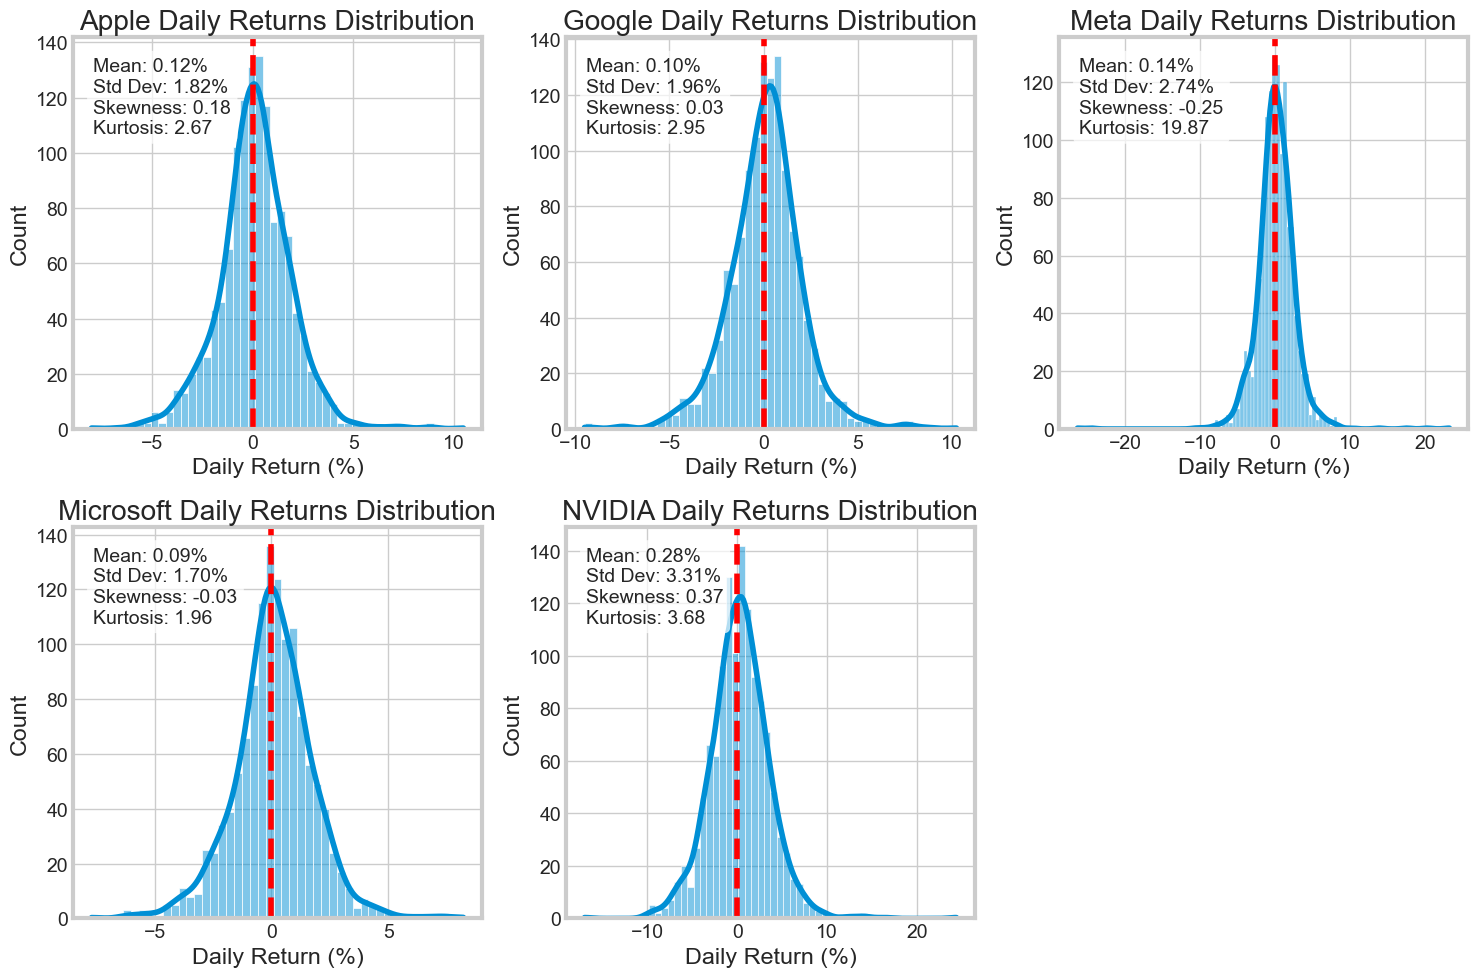

In [17]:
# Visualize daily returns distribution
plt.figure(figsize=(15, 10))
for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 3, i)
    returns = stock_data[ticker]['Daily_Return'].dropna()
    sns.histplot(returns, kde=True)
    plt.title(f'{ticker_names[ticker]} Daily Returns Distribution')
    plt.xlabel('Daily Return (%)')
    plt.axvline(x=0, color='red', linestyle='--')
    
    # Add statistics
    mean = returns.mean()
    std = returns.std()
    skew = returns.skew()
    kurt = returns.kurtosis()
    
    stats_text = f'Mean: {mean:.2f}%\nStd Dev: {std:.2f}%\nSkewness: {skew:.2f}\nKurtosis: {kurt:.2f}'
    plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                 va='top', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
plt.tight_layout()
plt.show()

In [18]:
# Correlation analysis between stocks
closing_prices = pd.DataFrame()
for ticker in tickers:
    closing_prices[ticker] = stock_data[ticker]['Close']

correlation = closing_prices.corr()

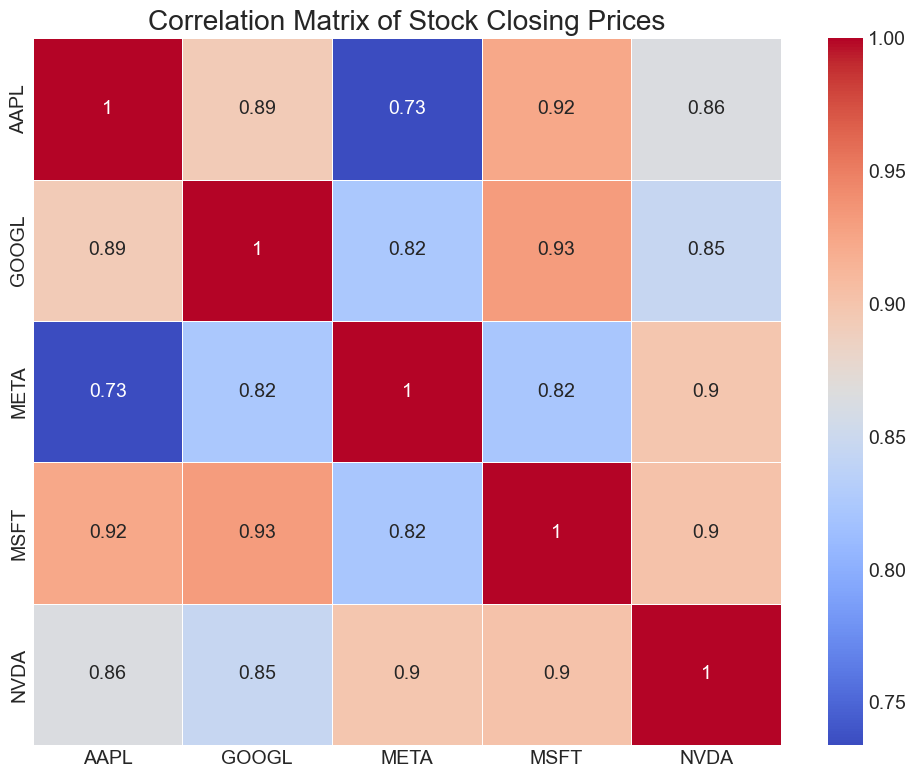

In [19]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.tight_layout()
plt.show()

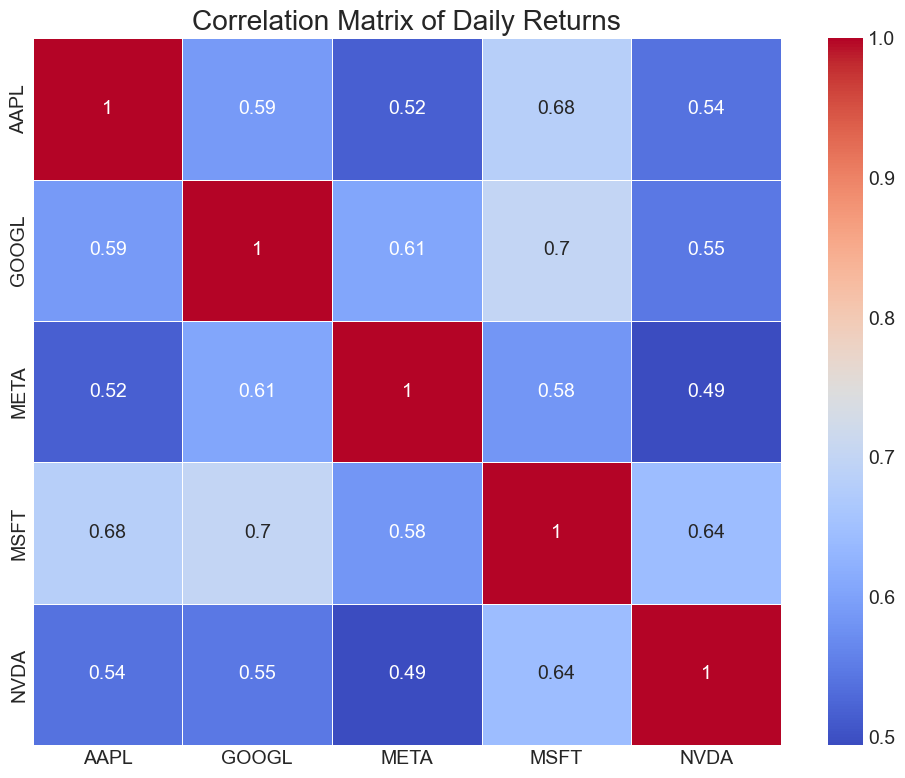

In [20]:
# Plot daily returns correlation
returns_df = pd.DataFrame()
for ticker in tickers:
    returns_df[ticker] = stock_data[ticker]['Daily_Return'].dropna()

returns_corr = returns_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(returns_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Daily Returns')
plt.tight_layout()
plt.show()

Augmented Dickey-Fuller Test for AAPL Close Price:
ADF Statistic: -2.053053
p-value: 0.263806
Critical Values:
	1%: -3.435575
	5%: -2.863848
	10%: -2.567999
Result: Series is NON-STATIONARY (fail to reject null hypothesis)


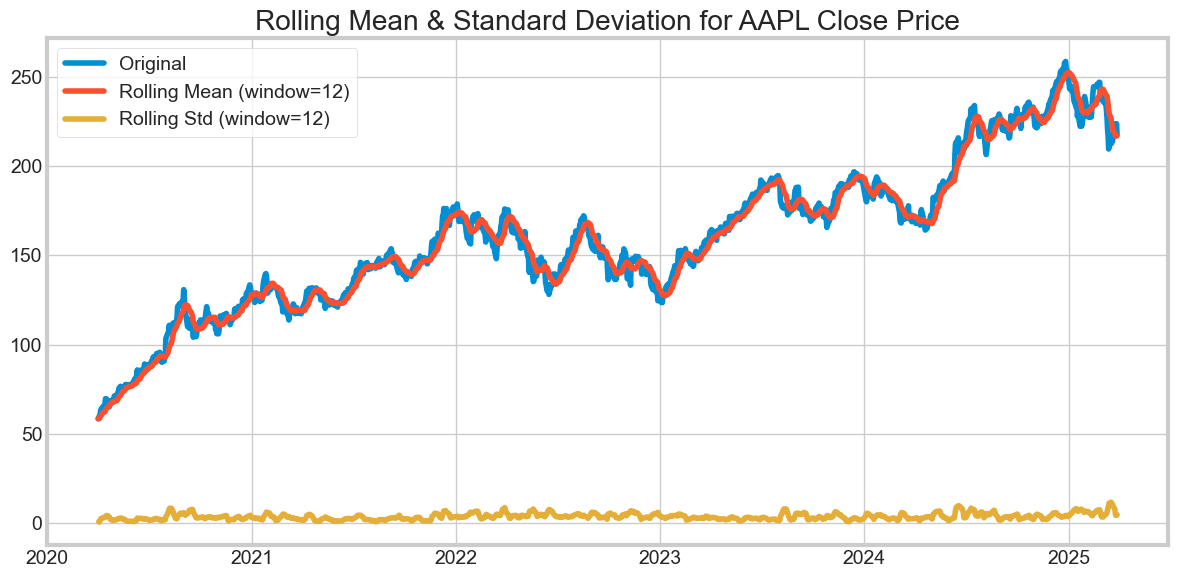

Augmented Dickey-Fuller Test for AAPL Daily Returns:
ADF Statistic: -36.005754
p-value: 0.000000
Critical Values:
	1%: -3.435580
	5%: -2.863849
	10%: -2.568000
Result: Series is STATIONARY (reject null hypothesis)


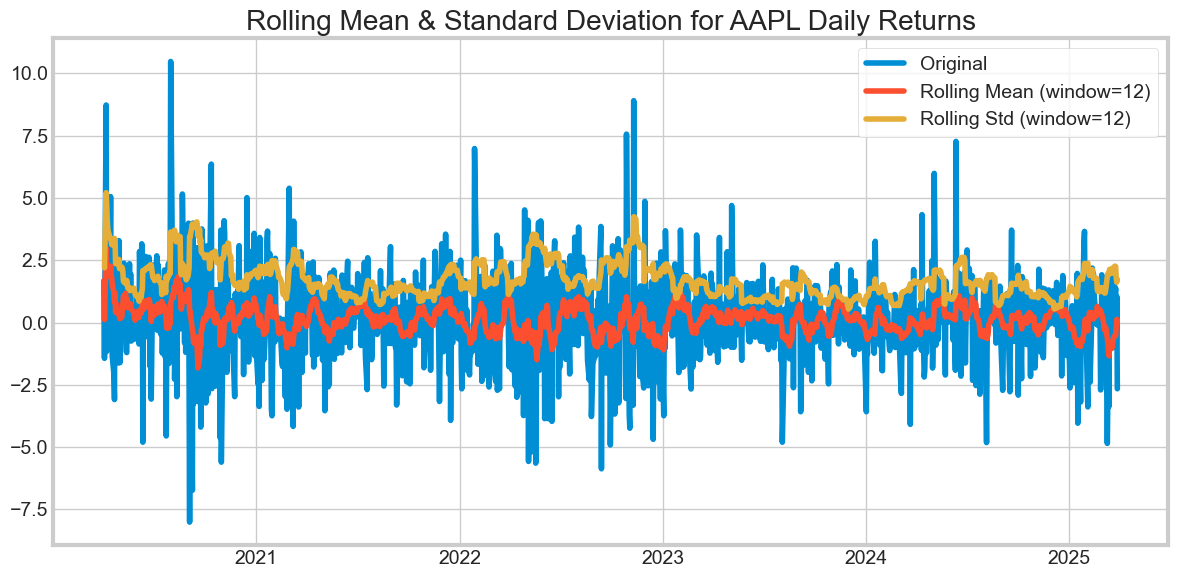

Augmented Dickey-Fuller Test for GOOGL Close Price:
ADF Statistic: -1.990472
p-value: 0.290766
Critical Values:
	1%: -3.435575
	5%: -2.863848
	10%: -2.567999
Result: Series is NON-STATIONARY (fail to reject null hypothesis)


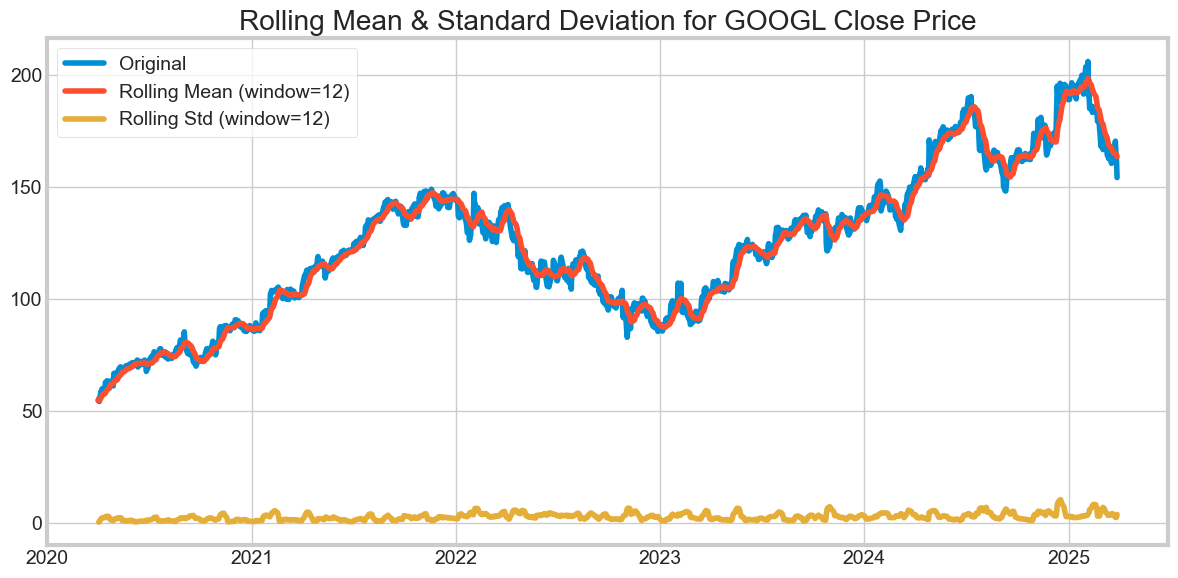

Augmented Dickey-Fuller Test for GOOGL Daily Returns:
ADF Statistic: -21.923041
p-value: 0.000000
Critical Values:
	1%: -3.435588
	5%: -2.863853
	10%: -2.568002
Result: Series is STATIONARY (reject null hypothesis)


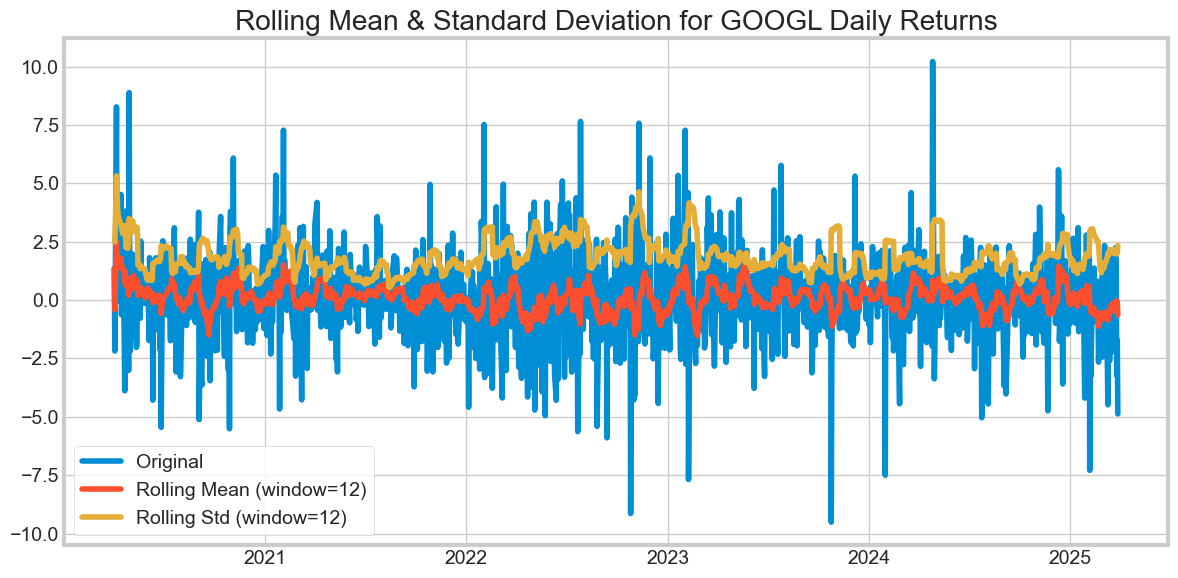

Augmented Dickey-Fuller Test for META Close Price:
ADF Statistic: -0.525210
p-value: 0.887002
Critical Values:
	1%: -3.435575
	5%: -2.863848
	10%: -2.567999
Result: Series is NON-STATIONARY (fail to reject null hypothesis)


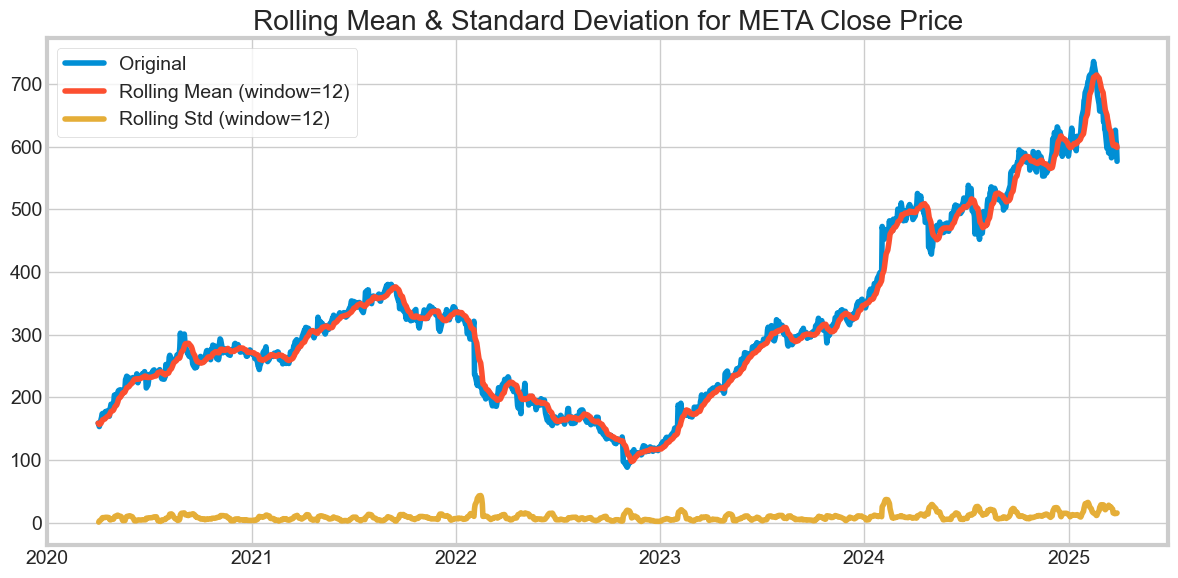

Augmented Dickey-Fuller Test for META Daily Returns:
ADF Statistic: -35.828885
p-value: 0.000000
Critical Values:
	1%: -3.435580
	5%: -2.863849
	10%: -2.568000
Result: Series is STATIONARY (reject null hypothesis)


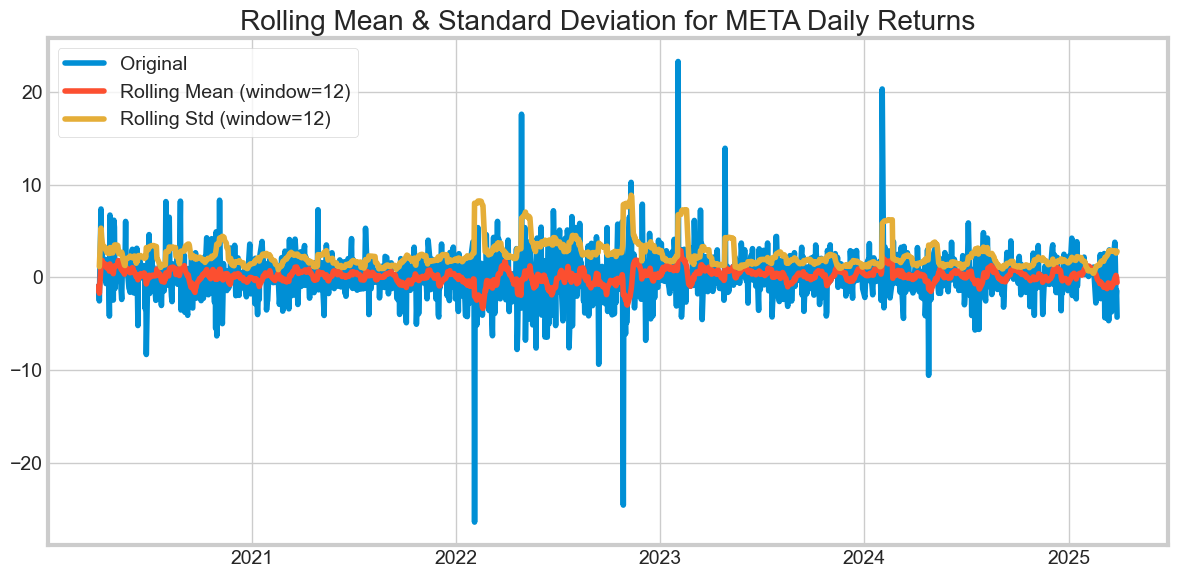

Augmented Dickey-Fuller Test for MSFT Close Price:
ADF Statistic: -1.672184
p-value: 0.445498
Critical Values:
	1%: -3.435584
	5%: -2.863851
	10%: -2.568001
Result: Series is NON-STATIONARY (fail to reject null hypothesis)


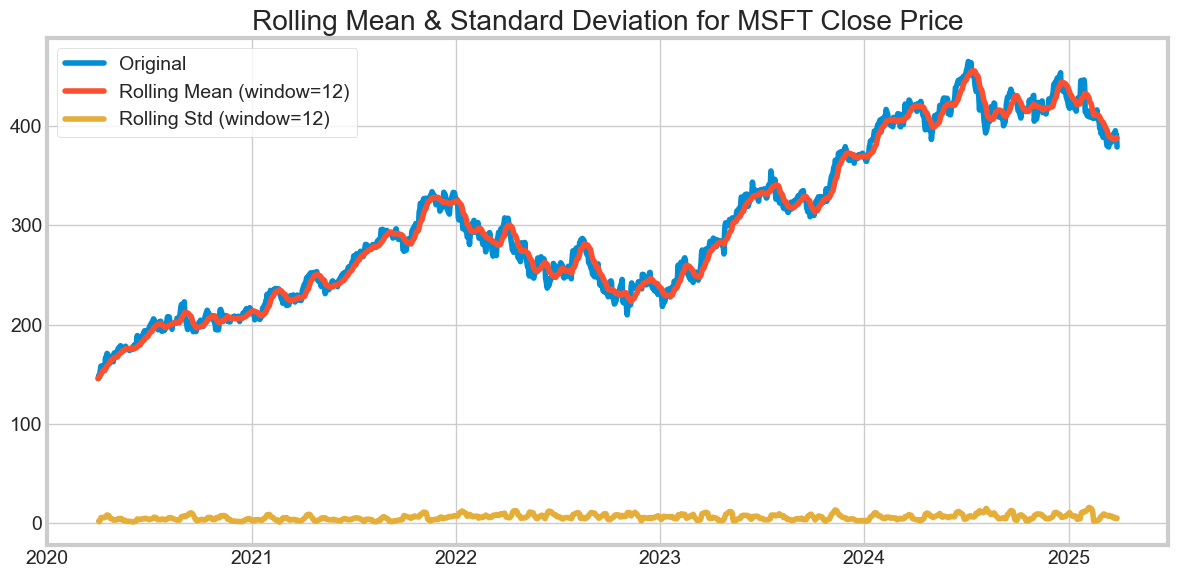

Augmented Dickey-Fuller Test for MSFT Daily Returns:
ADF Statistic: -22.607265
p-value: 0.000000
Critical Values:
	1%: -3.435588
	5%: -2.863853
	10%: -2.568002
Result: Series is STATIONARY (reject null hypothesis)


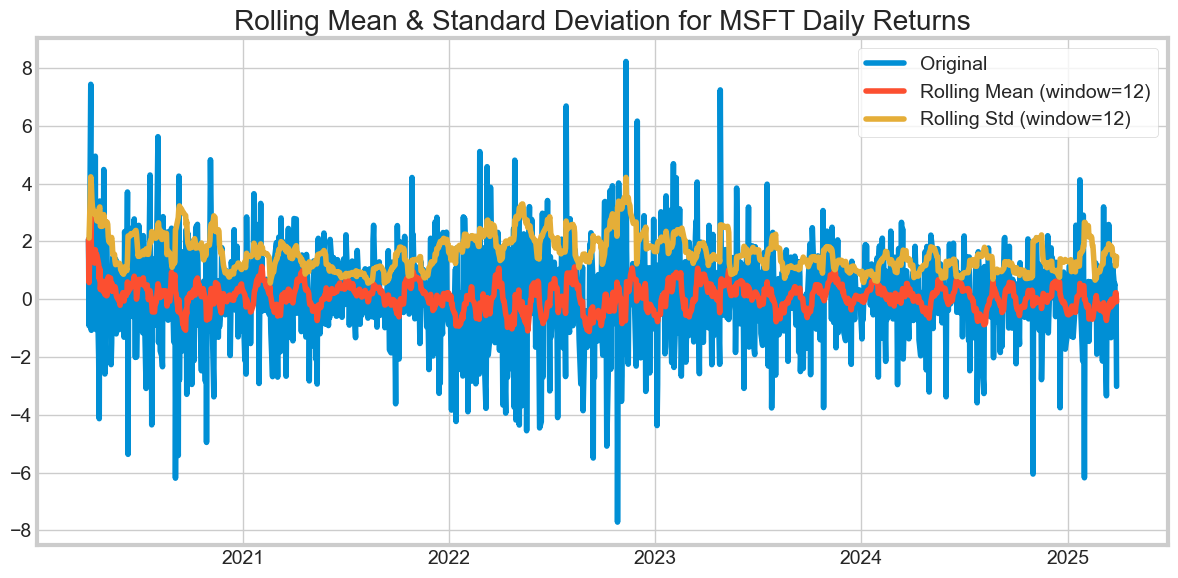

Augmented Dickey-Fuller Test for NVDA Close Price:
ADF Statistic: -0.316580
p-value: 0.923123
Critical Values:
	1%: -3.435669
	5%: -2.863889
	10%: -2.568021
Result: Series is NON-STATIONARY (fail to reject null hypothesis)


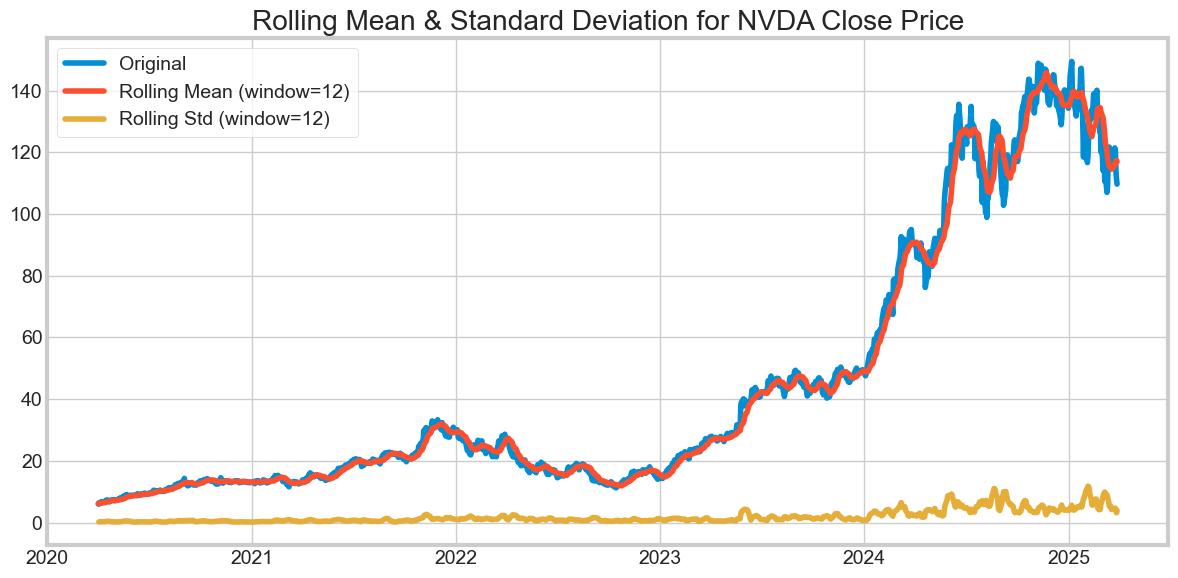

Augmented Dickey-Fuller Test for NVDA Daily Returns:
ADF Statistic: -37.601364
p-value: 0.000000
Critical Values:
	1%: -3.435580
	5%: -2.863849
	10%: -2.568000
Result: Series is STATIONARY (reject null hypothesis)


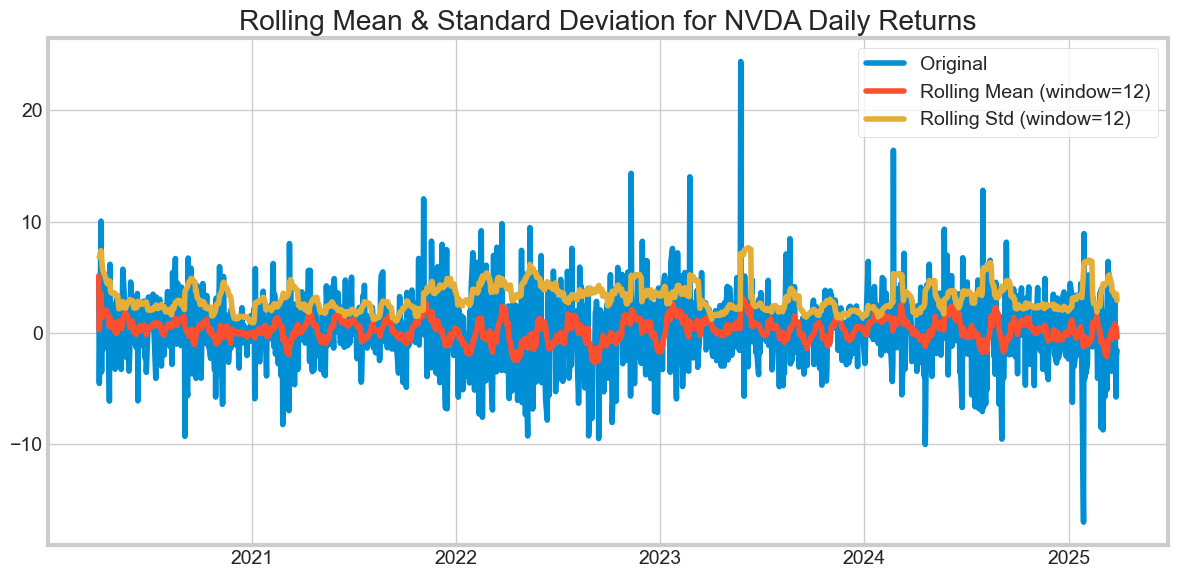

In [113]:
# Function to check for stationarity
def check_stationarity(series, window=12, title=''):
    """
    Check stationarity of a time series with Dickey-Fuller test
    Args:
        series: Pandas Series with time series data
        window: Rolling window size for mean/std calculations
        title: Title for the output
    """
    # Handle empty or all-NA series
    if series.dropna().empty:
        print(f"Cannot check stationarity for {title} - series is empty after dropping NA values")
        return
    
    # Rolling statistics
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    
    # Dickey-Fuller test
    try:
        result = adfuller(series.dropna())
    except Exception as e:
        print(f"Error performing ADF test for {title}: {str(e)}")
        return
    
    print(f'Augmented Dickey-Fuller Test for {title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.6f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("Result: Series is STATIONARY (reject null hypothesis)")
    else:
        print("Result: Series is NON-STATIONARY (fail to reject null hypothesis)")
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label=f'Rolling Mean (window={window})')
    plt.plot(rolling_std, label=f'Rolling Std (window={window})')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {title}')
    plt.tight_layout()
    plt.show()

def calculate_daily_returns(df):
    """Calculate daily returns if not present"""
    if 'Daily_Return' not in df.columns:
        df['Daily_Return'] = df['Close'].pct_change() * 100
    return df

# Check stationarity for each stock
for ticker in tickers:
    # Ensure Daily_Return exists
    stock_data[ticker] = calculate_daily_returns(stock_data[ticker])
    
    # Check stationarity of Close prices
    check_stationarity(stock_data[ticker]['Close'], title=f'{ticker} Close Price')
    
    # Check stationarity of Daily Returns (with NA handling)
    daily_returns = stock_data[ticker]['Daily_Return'].dropna()
    if not daily_returns.empty:
        check_stationarity(daily_returns, title=f'{ticker} Daily Returns')
    else:
        print(f"Skipping Daily Returns stationarity check for {ticker} - no valid data")

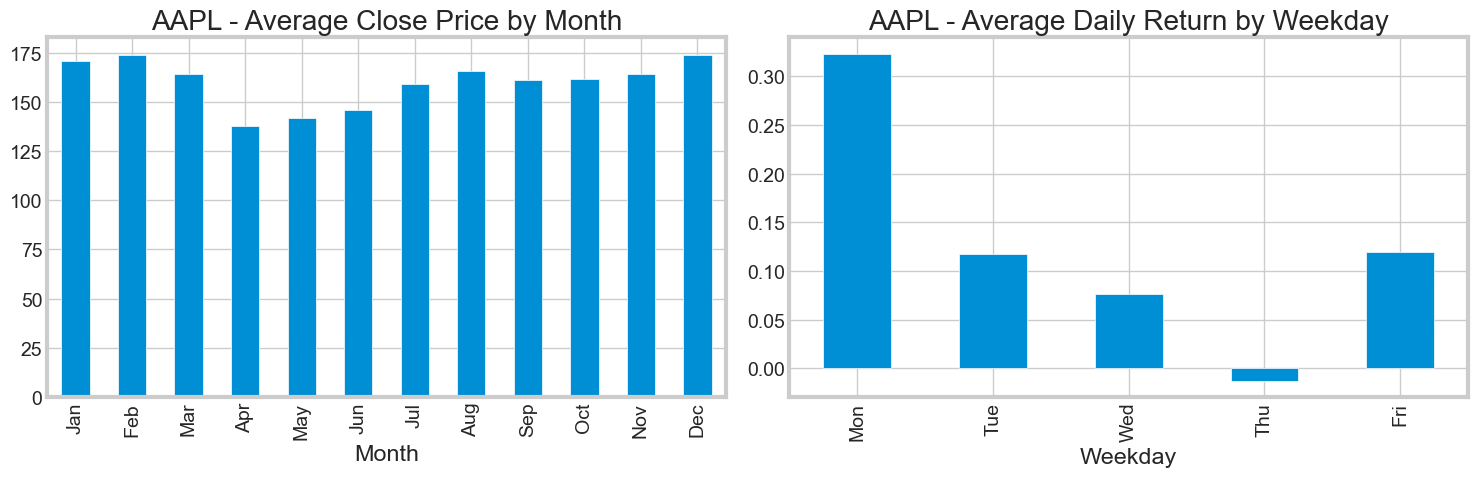

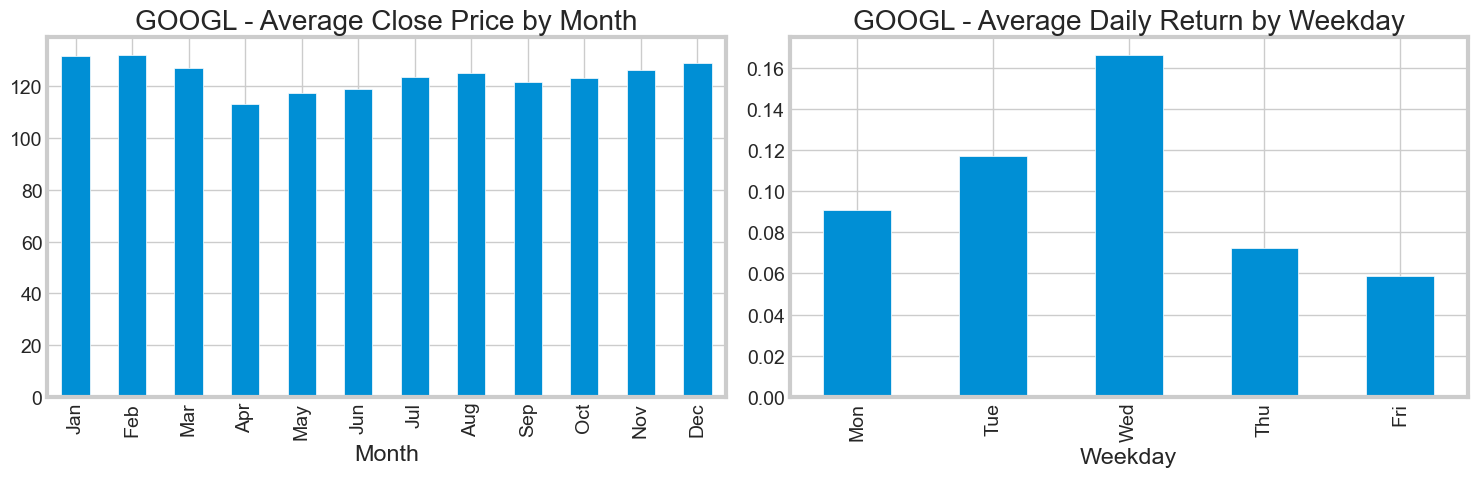

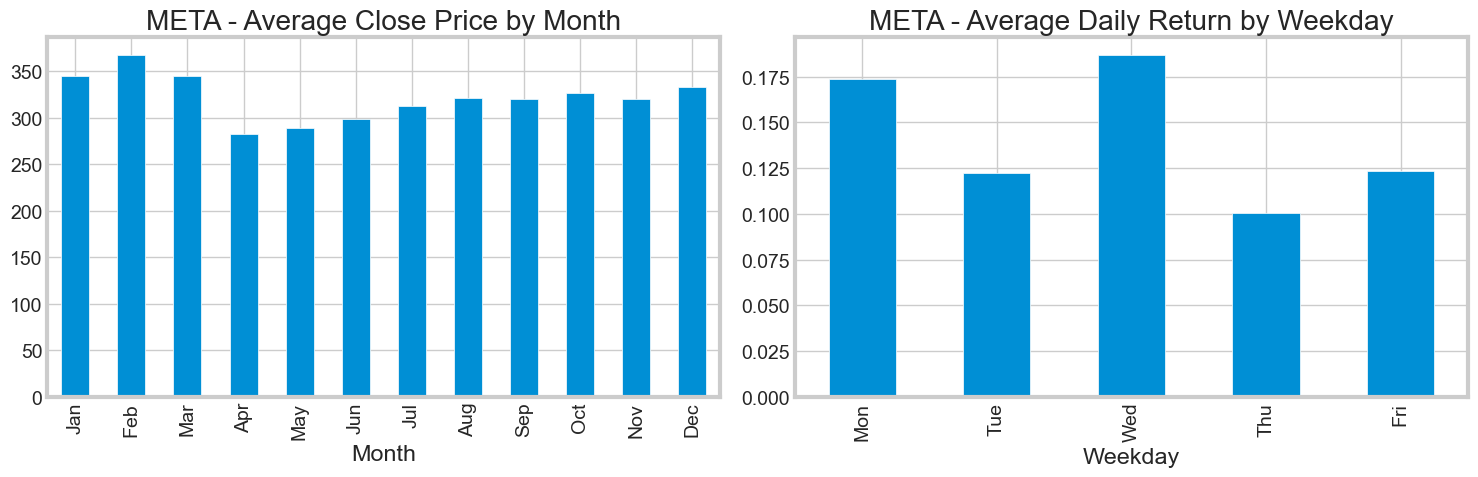

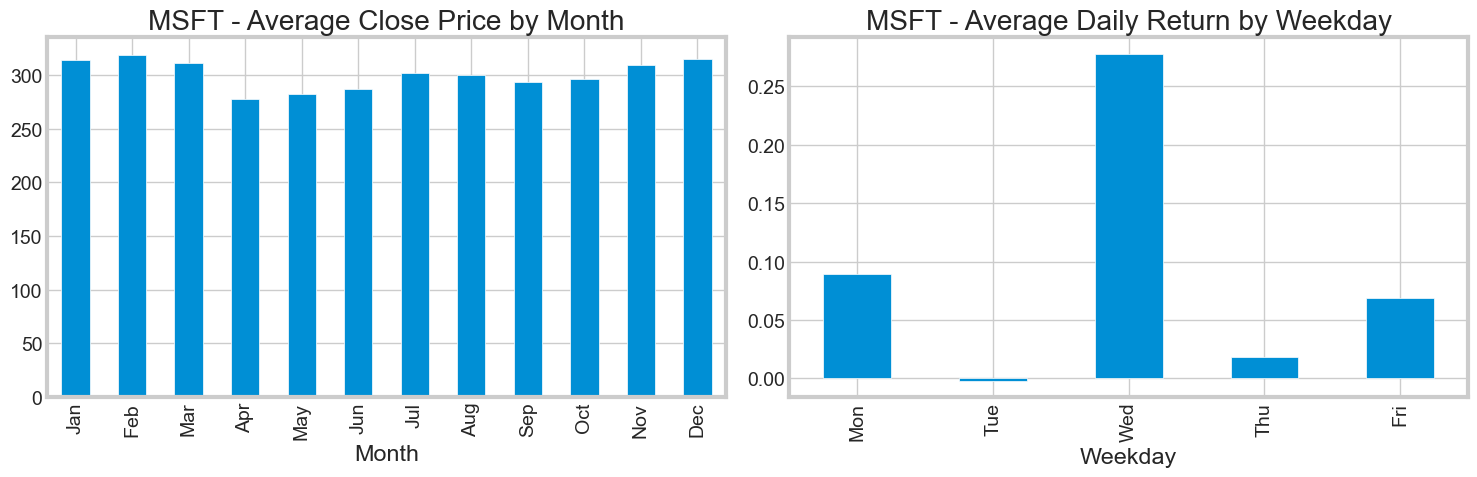

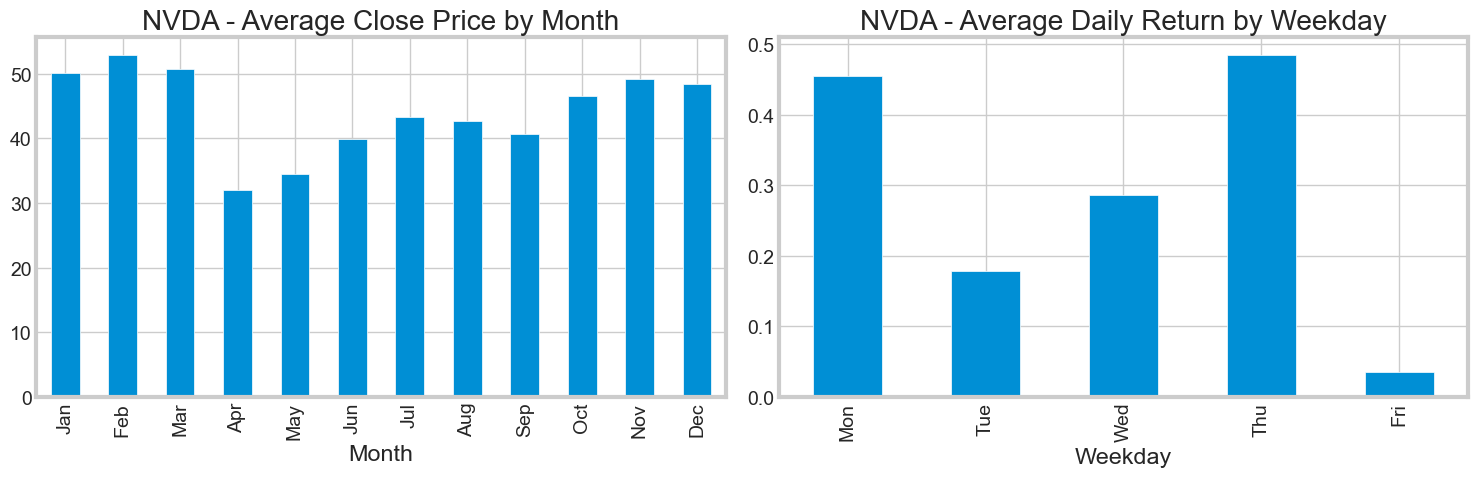

In [114]:
# Seasonality analysis
def plot_seasonality(ticker, df):
    df = df.copy()
    
    # Add date components
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Weekday'] = df.index.weekday
    
    # Monthly seasonality
    monthly_avg = df.groupby('Month')['Close'].mean()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    monthly_avg.plot(kind='bar')
    plt.title(f'{ticker} - Average Close Price by Month')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    # Weekday seasonality
    weekday_avg = df.groupby('Weekday')['Daily_Return'].mean()
    
    plt.subplot(1, 2, 2)
    weekday_avg.plot(kind='bar')
    plt.title(f'{ticker} - Average Daily Return by Weekday')
    plt.xticks(range(5), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
    
    plt.tight_layout()
    plt.show()

# Plot seasonality for each stock
for ticker in tickers:
    plot_seasonality(ticker, stock_data[ticker])

In [115]:
def engineer_features(df, ticker):
    print(f"Engineering features for {ticker}...")
    df = df.copy()
    
    # 1. Ensure required columns exist
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column {col} not found in dataframe")
    
    # 2. Create Daily_Return if it doesn't exist
    if 'Daily_Return' not in df.columns:
        df['Daily_Return'] = df['Close'].pct_change() * 100
    
    # 3. Ensure we have enough data
    if len(df) < 250:
        print(f"Warning: Not enough data for {ticker} to calculate all features")
        return df
    
    # 4. Price-based features
    windows = [5, 10, 20, 50, 200]
    for w in windows:
        df[f'SMA_{w}'] = df['Close'].rolling(window=w, min_periods=1).mean()
    
    # 5. Price crossing signals
    df['SMA_5_10_cross'] = np.where(df['SMA_5'] > df['SMA_10'], 1, -1)
    df['SMA_10_20_cross'] = np.where(df['SMA_10'] > df['SMA_20'], 1, -1)
    df['SMA_50_200_cross'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
    
    # 6. Relative price position
    df['Price_to_SMA_50'] = df['Close'] / df['SMA_50'].replace(0, np.nan)
    df['Price_to_SMA_200'] = df['Close'] / df['SMA_200'].replace(0, np.nan)
    
    # 7. Volatility features
    volatility_windows = [10, 20, 50]
    for w in volatility_windows:
        df[f'Volatility_{w}'] = df['Daily_Return'].rolling(window=w, min_periods=1).std()
    
    # 8. Range and gaps
    df['Daily_Range'] = (df['High'] - df['Low']) / df['Open'].replace(0, np.nan) * 100
    df['Gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1).replace(0, np.nan) * 100
    
    # 9. Exponential Moving Averages
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    
    # 10. MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    
    # 11. RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss.replace(0, np.nan)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 12. Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['BB_Std'] = df['Close'].rolling(window=20, min_periods=1).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle'].replace(0, np.nan)
    
    # 13. Lag features
    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Return_Lag_{lag}'] = df['Daily_Return'].shift(lag)
    
    # 14. Return over different periods
    df['Return_5d'] = df['Close'].pct_change(5) * 100
    df['Return_10d'] = df['Close'].pct_change(10) * 100
    df['Return_20d'] = df['Close'].pct_change(20) * 100
    
    # 15. Volume features
    df['Volume_SMA_5'] = df['Volume'].rolling(window=5, min_periods=1).mean()
    df['Volume_SMA_20'] = df['Volume'].rolling(window=20, min_periods=1).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20'].replace(0, np.nan)
    
    # 16. Price/Volume relationship
    df['Price_Volume_Ratio'] = df['Close'] * df['Volume']
    
    # 17. Momentum indicators
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5).replace(0, np.nan) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10).replace(0, np.nan) - 1
    df['Momentum_20'] = df['Close'] / df['Close'].shift(20).replace(0, np.nan) - 1
    
    # 18. Date features
    df['Month'] = df.index.month
    df['Day_of_week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    
    # 19. Cyclic encoding
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Weekday_sin'] = np.sin(2 * np.pi * df['Day_of_week'] / 5)
    df['Weekday_cos'] = np.cos(2 * np.pi * df['Day_of_week'] / 5)
    
    # 20. Target variable
    df['Next_Close'] = df['Close'].shift(-1)
    
    # 21. Final cleaning
    initial_count = len(df)
    df_clean = df.ffill().bfill().dropna()
    removed_count = initial_count - len(df_clean)
    print(f"Removed {removed_count} rows with NaN values ({(removed_count/initial_count)*100:.2f}%)")
    
    return df_clean

# Engineer features for each stock
engineered_data = {}
for ticker, df in stock_data.items():
    engineered_data[ticker] = engineer_features(df, ticker)
    # Save engineered data
    engineered_data[ticker].to_csv(f'artifacts/{ticker}_engineered.csv')
    print(f"Saved engineered data for {ticker} to artifacts/{ticker}_engineered.csv")

Engineering features for AAPL...
Removed 0 rows with NaN values (0.00%)
Saved engineered data for AAPL to E:/INVESTO-Stock-Predictor/artifacts/AAPL_engineered.csv
Engineering features for GOOGL...
Removed 0 rows with NaN values (0.00%)
Saved engineered data for GOOGL to E:/INVESTO-Stock-Predictor/artifacts/GOOGL_engineered.csv
Engineering features for META...
Removed 0 rows with NaN values (0.00%)
Saved engineered data for META to E:/INVESTO-Stock-Predictor/artifacts/META_engineered.csv
Engineering features for MSFT...
Removed 0 rows with NaN values (0.00%)
Saved engineered data for MSFT to E:/INVESTO-Stock-Predictor/artifacts/MSFT_engineered.csv
Engineering features for NVDA...
Removed 0 rows with NaN values (0.00%)
Saved engineered data for NVDA to E:/INVESTO-Stock-Predictor/artifacts/NVDA_engineered.csv


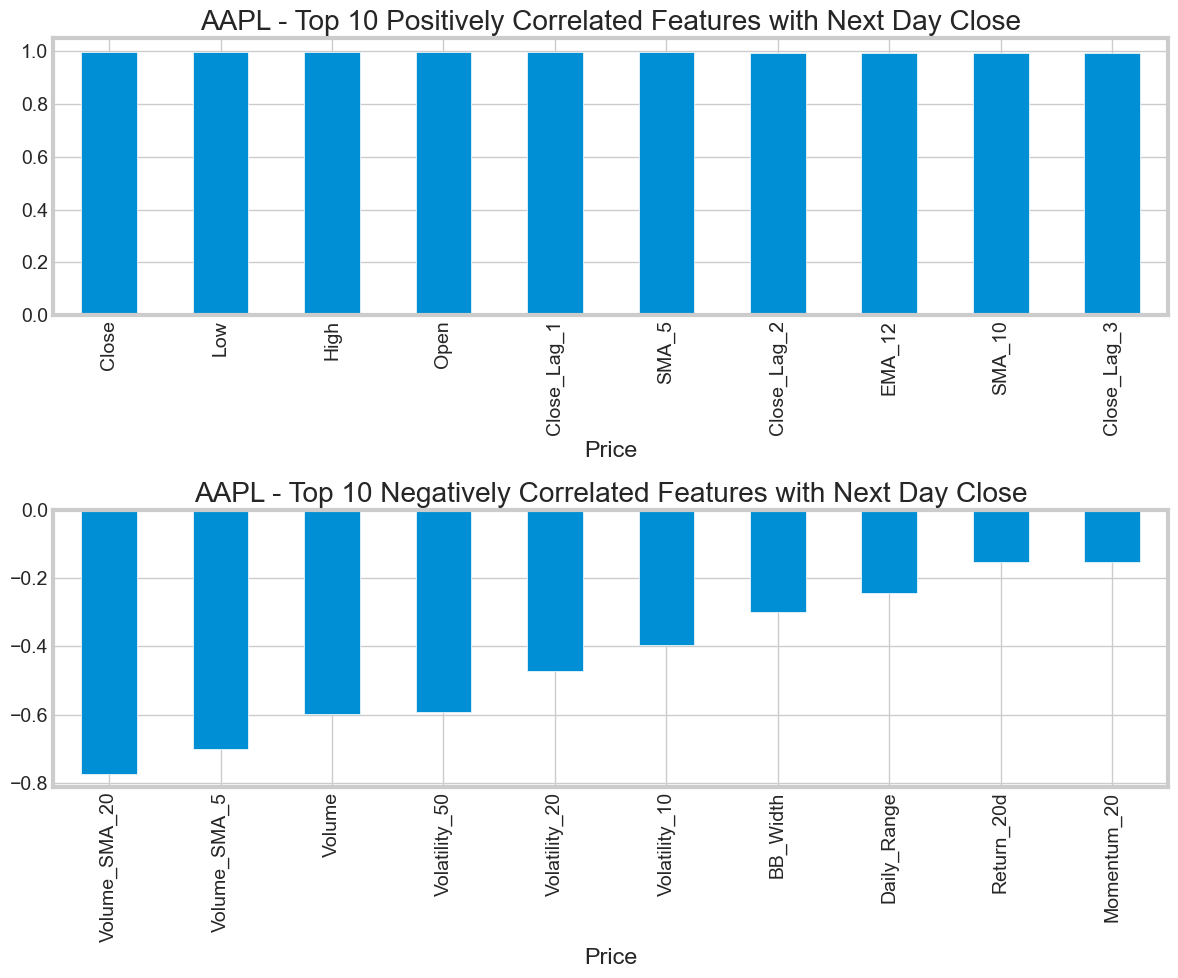

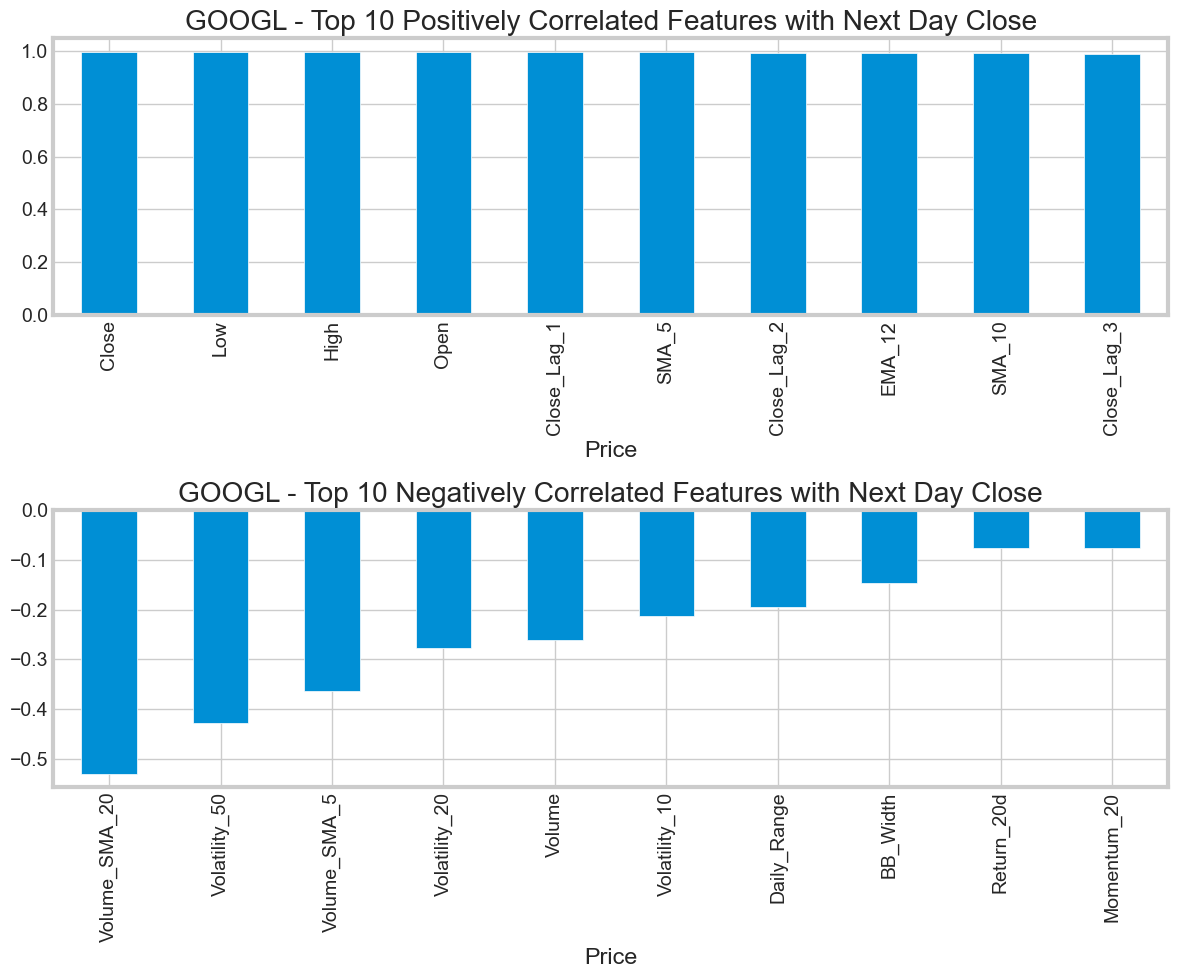

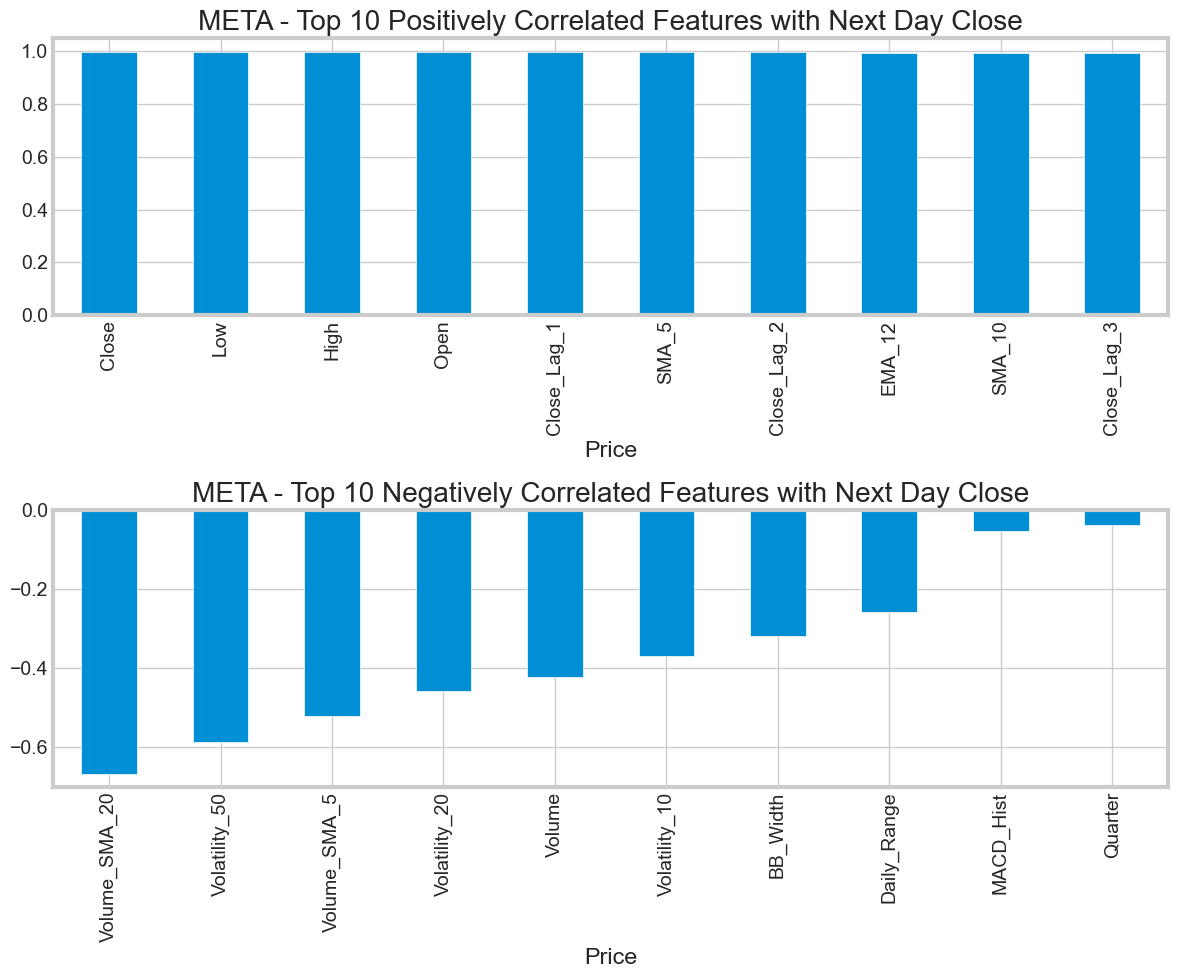

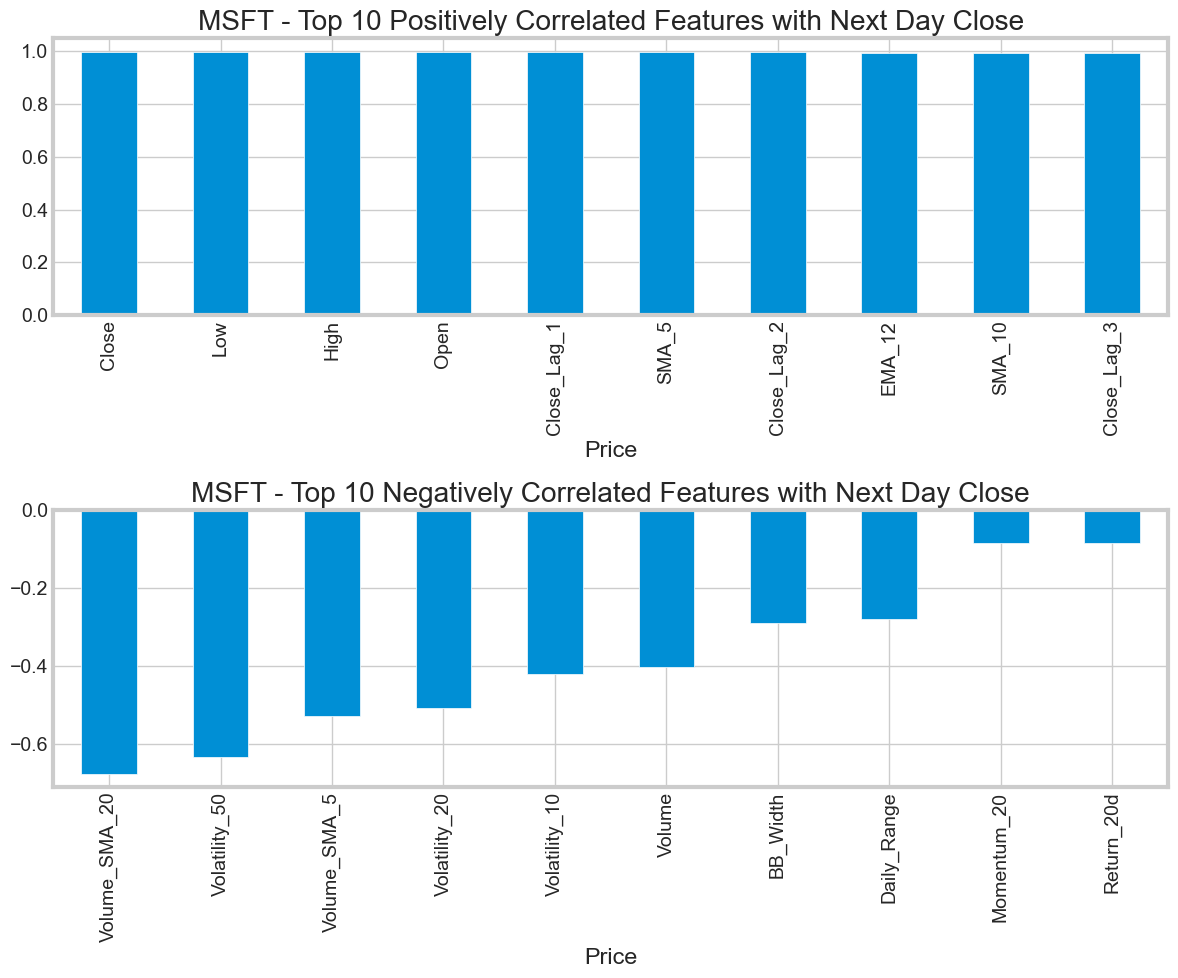

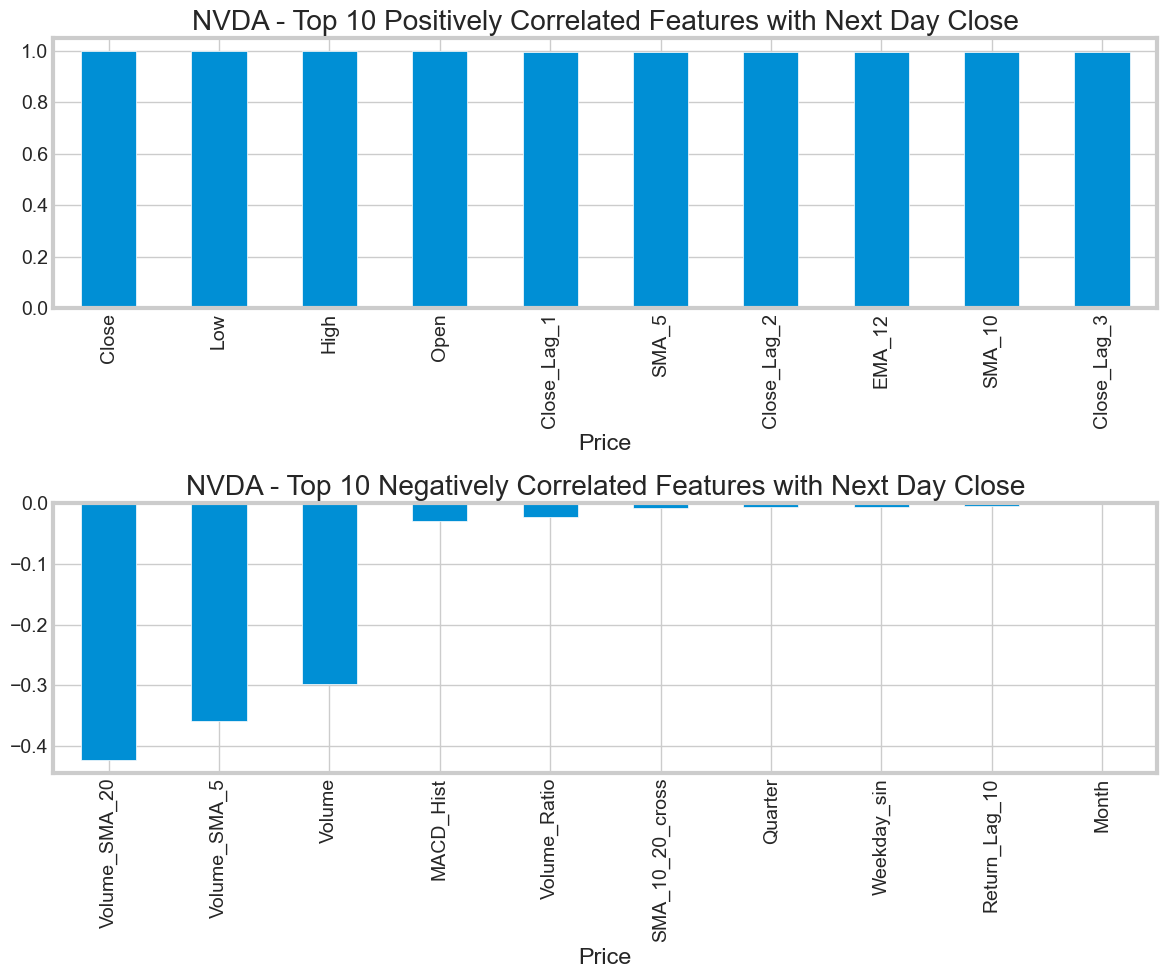

In [116]:
# Feature importance visualization using correlation with target
def plot_feature_correlation(df, ticker, n_features=15):
    # Calculate correlation with target
    corr_with_target = df.corr()['Next_Close'].drop('Next_Close').sort_values(ascending=False)
    
    # Get top positive and negative correlations
    top_pos = corr_with_target.nlargest(n_features)
    top_neg = corr_with_target.nsmallest(n_features)
    
    # Combine and plot
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    top_pos.plot(kind='bar')
    plt.title(f'{ticker} - Top {n_features} Positively Correlated Features with Next Day Close')
    plt.tight_layout()
    
    plt.subplot(2, 1, 2)
    top_neg.plot(kind='bar')
    plt.title(f'{ticker} - Top {n_features} Negatively Correlated Features with Next Day Close')
    
    plt.tight_layout()
    plt.show()

# Plot feature correlation for each stock
for ticker, df in engineered_data.items():
    plot_feature_correlation(df, ticker, n_features=10)

In [118]:
# Prepare data for modeling - split data and save
def prepare_modeling_data(df, ticker, test_size=0.2):
    # Separate features and target
    features = df.drop(['Next_Close'], axis=1)
    target = df['Next_Close']
    
    # Define non-feature columns to exclude
    exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily_Return']
    feature_cols = [col for col in features.columns if col not in exclude_cols]
    
    # Create X and y
    X = features[feature_cols]
    y = target
    
    # Time-based split (no shuffling)
    split_idx = int(len(X) * (1 - test_size))
    
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Create dataset dictionary
    datasets = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled_df,
        'X_test_scaled': X_test_scaled_df,
        'feature_names': feature_cols,
        'full_data': df
    }
    
    # ========== FIXED PATH HANDLING ==========
    artifacts_dir = os.path.join('E:', os.sep, 'INVESTO-Stock-Predictor', 'artifacts')
    os.makedirs(artifacts_dir, exist_ok=True)
    
    # Save datasets
    for name, data in datasets.items():
        if isinstance(data, list):
            continue
        file_path = os.path.join(artifacts_dir, f'{ticker}_{name}.csv')
        data.to_csv(file_path)
    
    # Save scaler
    scaler_path = os.path.join(artifacts_dir, f'{ticker}_scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Prepared and saved modeling data for {ticker}")
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    print(f"Artifacts saved to: {artifacts_dir}")
    
    return datasets

# Prepare modeling data for each stock
modeling_data = {}
for ticker, df in engineered_data.items():
    modeling_data[ticker] = prepare_modeling_data(df, ticker)

Prepared and saved modeling data for AAPL
Training set: (1004, 53), Test set: (251, 53)
Artifacts saved to: E:\INVESTO-Stock-Predictor\artifacts
Prepared and saved modeling data for GOOGL
Training set: (1004, 53), Test set: (251, 53)
Artifacts saved to: E:\INVESTO-Stock-Predictor\artifacts
Prepared and saved modeling data for META
Training set: (1004, 53), Test set: (251, 53)
Artifacts saved to: E:\INVESTO-Stock-Predictor\artifacts
Prepared and saved modeling data for MSFT
Training set: (1004, 53), Test set: (251, 53)
Artifacts saved to: E:\INVESTO-Stock-Predictor\artifacts
Prepared and saved modeling data for NVDA
Training set: (1004, 53), Test set: (251, 53)
Artifacts saved to: E:\INVESTO-Stock-Predictor\artifacts


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
import pickle
from datetime import datetime, timedelta

# Statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go

# Machine learning
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
import lightgbm as lgb
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import product

In [57]:
# Set up plotting styles
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [ ]:
# Function to load datasets
def load_data(ticker):
    datasets = {}
    
    # Load train and test sets
    datasets['X_train'] = pd.read_csv(f'artifacts/{ticker}_X_train.csv', index_col=0, parse_dates=True)
    datasets['X_test'] = pd.read_csv(f'artifacts/{ticker}_X_test.csv', index_col=0, parse_dates=True)
    datasets['y_train'] = pd.read_csv(f'artifacts/{ticker}_y_train.csv', index_col=0, parse_dates=True).squeeze("columns")
    datasets['y_test'] = pd.read_csv(f'artifacts/{ticker}_y_test.csv', index_col=0, parse_dates=True).squeeze("columns")
    datasets['X_train_scaled'] = pd.read_csv(f'artifacts/{ticker}_X_train_scaled.csv', index_col=0, parse_dates=True)
    datasets['X_test_scaled'] = pd.read_csv(f'artifacts/{ticker}_X_test_scaled.csv', index_col=0, parse_dates=True)
    
    # Load full engineered data for time series analysis
    datasets['full_data'] = pd.read_csv(f'artifacts/{ticker}_engineered.csv', index_col=0, parse_dates=True)
    
    # Load scaler
    with open(f'artifacts/{ticker}_scaler.pkl', 'rb') as f:
        datasets['scaler'] = pickle.load(f)
    
    print(f"Loaded data for {ticker}")
    return datasets

# Load data for all tickers
data = {}
for ticker in tickers:
    data[ticker] = load_data(ticker)

Loaded data for AAPL
Loaded data for GOOGL
Loaded data for META
Loaded data for MSFT
Loaded data for NVDA


In [59]:
def check_data_for_nans(folder_path="artifacts/"):
    """
    Check all CSV files in the artifacts folder for NaN values
    
    Args:
        folder_path: Path to the artifacts folder
    """
    print("Checking files in", folder_path)
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            try:
                filepath = os.path.join(folder_path, file)
                df = pd.read_csv(filepath)
                
                # Check for NaN values
                nan_count = df.isna().sum().sum()
                nan_percent = (nan_count / df.size) * 100
                
                print(f"\nFile: {file}")
                print(f"Total NaN values: {nan_count}")
                print(f"Percentage of NaN values: {nan_percent:.2f}%")
                
                # Show columns with NaN values
                if nan_count > 0:
                    print("NaN count by column:")
                    nan_columns = df.columns[df.isna().any()].tolist()
                    for col in nan_columns:
                        col_nan_count = df[col].isna().sum()
                        col_nan_percent = (col_nan_count / len(df)) * 100
                        print(f"  {col}: {col_nan_count} ({col_nan_percent:.2f}%)")
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
    
    print("\nData check complete.")

# Run the check
check_data_for_nans()

Checking files in E:/INVESTO-Stock-Predictor/artifacts/

File: AAPL_engineered.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_full_data.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_raw.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_X_test.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_X_test_scaled.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_X_train.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_X_train_scaled.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_y_test.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: AAPL_y_train.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: GOOGL_engineered.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: GOOGL_full_data.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: GOOGL_raw.csv
Total NaN values: 0
Percentage of NaN values: 0.00%

File: GOOGL_X_t

In [60]:
def inspect_data_structure(data):
    """Inspect the data structure to help diagnose issues"""
    print("\n=== Inspecting Data Structure ===\n")
    
    # Check the top-level structure
    print(f"Data type: {type(data)}")
    
    if isinstance(data, dict):
        print(f"Top-level keys: {list(data.keys())}")
        
        # Check if 'AAPL' or another ticker is a key
        ticker_found = False
        for ticker in ['AAPL', 'MSFT', 'GOOG', 'AMZN']:
            if ticker in data:
                ticker_found = True
                print(f"\nExamining {ticker} data:")
                ticker_data = data[ticker]
                print(f"Type: {type(ticker_data)}")
                
                if isinstance(ticker_data, dict):
                    print(f"Keys: {list(ticker_data.keys())}")
                    
                    # Try to find price data
                    if 'Close' in ticker_data:
                        print("Close data found")
                        close_data = ticker_data['Close']
                        print(f"Type: {type(close_data)}")
                        print(f"Length: {len(close_data) if hasattr(close_data, '__len__') else 'N/A'}")
                        if hasattr(close_data, '__len__') and len(close_data) > 0:
                            print(f"First few values: {close_data[:5]}")
                    else:
                        print("No 'Close' key found")
                        # Check a sample of other keys
                        for key in list(ticker_data.keys())[:3]:
                            value = ticker_data[key]
                            print(f"Sample key '{key}':")
                            print(f"  Type: {type(value)}")
                            if hasattr(value, '__len__'):
                                print(f"  Length: {len(value)}")
                                if len(value) > 0:
                                    print(f"  First few values: {value[:5]}")
                
                elif hasattr(ticker_data, 'columns'):  # DataFrame
                    print(f"Columns: {list(ticker_data.columns)}")
                    if 'Close' in ticker_data.columns:
                        print("Close column found")
                        print(f"First few values: {ticker_data['Close'].head().tolist()}")
                    else:
                        print("No 'Close' column found")
                
                else:
                    print("Data is neither dict nor DataFrame")
                    if hasattr(ticker_data, '__len__'):
                        print(f"Length: {len(ticker_data)}")
                        if len(ticker_data) > 0:
                            print(f"First few values: {ticker_data[:5]}")
                
                break
        
        if not ticker_found:
            # If no ticker keys found, examine the first key
            if len(data) > 0:
                first_key = list(data.keys())[0]
                print(f"\nExamining first key '{first_key}':")
                first_value = data[first_key]
                print(f"Type: {type(first_value)}")
                
                if isinstance(first_value, dict):
                    print(f"Keys: {list(first_value.keys())}")
                elif hasattr(first_value, 'columns'):  # DataFrame
                    print(f"Columns: {list(first_value.columns)}")
                elif hasattr(first_value, '__len__'):
                    print(f"Length: {len(first_value)}")
                    if len(first_value) > 0:
                        print(f"First few values: {first_value[:5]}")
    
    elif hasattr(data, 'columns'):  # DataFrame
        print(f"DataFrame columns: {list(data.columns)}")
        print(f"DataFrame shape: {data.shape}")
        print(f"DataFrame head:\n{data.head()}")
    
    else:
        print("Data is neither dict nor DataFrame")
        if hasattr(data, '__len__'):
            print(f"Length: {len(data)}")
            if len(data) > 0:
                print(f"First few values: {data[:5]}")
    
    print("\n=== End of Data Inspection ===\n")

# Use this to inspect your data structure
inspect_data_structure(data)


=== Inspecting Data Structure ===

Data type: <class 'dict'>
Top-level keys: ['AAPL', 'GOOGL', 'META', 'MSFT', 'NVDA']

Examining AAPL data:
Type: <class 'dict'>
Keys: ['X_train', 'X_test', 'y_train', 'y_test', 'X_train_scaled', 'X_test_scaled', 'full_data', 'scaler']
No 'Close' key found
Sample key 'X_train':
  Type: <class 'pandas.core.frame.DataFrame'>
  Length: 1004
  First few values:                 SMA_5     SMA_10     SMA_20     SMA_50    SMA_200  \
Date                                                                
2020-04-01  58.463806  58.463806  58.463806  58.463806  58.463806   
2020-04-02  58.951590  58.951590  58.951590  58.951590  58.951590   
2020-04-03  58.829442  58.829442  58.829442  58.829442  58.829442   
2020-04-06  60.046071  60.046071  60.046071  60.046071  60.046071   
2020-04-07  60.628498  60.628498  60.628498  60.628498  60.628498   

            SMA_5_10_cross  SMA_10_20_cross  SMA_50_200_cross  \
Date                                                     

In [65]:
def auto_arima(time_series, max_p=3, max_d=2, max_q=3, 
                      seasonal=False, max_P=2, max_D=1, max_Q=2, m=12,
                      information_criterion='aic', max_order=None,
                      max_tries=50, timeout=60):
    """
    Implementation of auto_arima that is more robust to challenging datasets.
    """
    # Ensure time_series is a pandas Series
    if not isinstance(time_series, pd.Series):
        time_series = pd.Series(time_series)
    
    # Handle missing values
    time_series = time_series.fillna(method='ffill').fillna(method='bfill')
    
    # Check for constant series
    if time_series.std() == 0:
        print("Warning: Constant time series. Cannot fit ARIMA model.")
        return None, (0, 0, 0)
    
    # Check minimum length
    if len(time_series) < 10:
        print("Warning: Time series too short. Need at least 10 observations.")
        return None, (0, 0, 0)
    
    print("Checking stationarity...")
    
    # Determine reasonable 'd' parameter using stationarity tests
    d_values = list(range(max_d + 1))
    
    # ADF Test - H0: series is not stationary
    adf_result = adfuller(time_series, regression='c')
    adf_stationary = adf_result[1] < 0.05
    
    # If the series is already stationary, prioritize d=0
    if adf_stationary:
        d_values = [0] + d_values[1:]
        print("Series is stationary according to ADF test.")
    else:
        print("Series is not stationary according to ADF test.")
        
        # Try KPSS test as well - H0: series is stationary
        try:
            from statsmodels.tsa.stattools import kpss
            kpss_result = kpss(time_series, regression='c')
            kpss_stationary = kpss_result[1] > 0.05
            
            if not kpss_stationary:
                print("KPSS test confirms non-stationarity.")
                # Prioritize d=1 since both tests indicate non-stationarity
                if 1 in d_values:
                    d_values.remove(1)
                    d_values = [1] + d_values
            else:
                print("KPSS test suggests stationarity. Results conflict with ADF.")
        except:
            print("KPSS test failed. Continuing with ADF results.")
    
    # Determine seasonal D if applicable
    D_values = list(range(max_D + 1))
    if seasonal and len(time_series) > m * 2:
        # Check seasonal stationarity by looking at seasonal differences
        seasonal_diff = time_series.diff(m).dropna()
        if len(seasonal_diff) > 10:
            try:
                seasonal_adf = adfuller(seasonal_diff, regression='c')
                if seasonal_adf[1] < 0.05:
                    # Seasonal differencing made it stationary
                    if 1 in D_values:
                        D_values.remove(1)
                        D_values = [1] + D_values
            except:
                print("Seasonal stationarity test failed. Using default D values.")
    
    # Function to evaluate an ARIMA model with error handling
    def evaluate_arima(order, seasonal_order=None):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                if seasonal and seasonal_order is not None:
                    model = SARIMAX(time_series, 
                                   order=order, 
                                   seasonal_order=seasonal_order,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
                else:
                    model = ARIMA(time_series, order=order)
                
                model_fit = model.fit(method='powell', disp=False, maxiter=100)
                
                # Get information criterion
                if information_criterion.lower() == 'aic':
                    ic = model_fit.aic
                elif information_criterion.lower() == 'bic':
                    ic = model_fit.bic
                elif information_criterion.lower() == 'hqic':
                    ic = model_fit.hqic
                else:
                    ic = model_fit.aic
                
                return ic, model_fit
                
        except Exception as e:
            return float('inf'), None
    
    # Generate parameter combinations
    p_values = range(max_p + 1)
    q_values = range(max_q + 1)
    
    parameter_combinations = []
    
    if seasonal:
        P_values = range(max_P + 1)
        Q_values = range(max_Q + 1)
        
        # Generate non-seasonal combinations
        for p, d, q in product(p_values, d_values, q_values):
            if max_order is not None and p + q > max_order:
                continue
            parameter_combinations.append((p, d, q, None))
        
        # Generate seasonal combinations
        for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
            if max_order is not None and p + q + P + Q > max_order:
                continue
            if P == 0 and D == 0 and Q == 0:
                continue  # Skip if no seasonal component
            parameter_combinations.append((p, d, q, (P, D, Q, m)))
    else:
        for p, d, q in product(p_values, d_values, q_values):
            if max_order is not None and p + q > max_order:
                continue
            parameter_combinations.append((p, d, q, None))
    
    # Limit number of combinations to max_tries
    if max_tries < len(parameter_combinations):
        # Prioritize some combinations
        prioritized = []
        # Classic models
        for order in [(1,1,1), (0,1,1), (1,1,0), (2,1,2)]:
            if order[1] in d_values and order in [(p,d,q) for p,d,q,_ in parameter_combinations]:
                prioritized.append((order[0], order[1], order[2], None))
        
        # Add other combinations
        remaining = [comb for comb in parameter_combinations if comb not in prioritized]
        np.random.shuffle(remaining)
        parameter_combinations = prioritized + remaining
        parameter_combinations = parameter_combinations[:max_tries]
    
    print(f"Testing {len(parameter_combinations)} parameter combinations...")
    
    best_ic = float('inf')
    best_model = None
    best_config = None
    
    start_time = time.time()
    
    for i, (p, d, q, seasonal_order) in enumerate(parameter_combinations):
        if time.time() - start_time > timeout:
            print(f"Timeout reached after testing {i} combinations.")
            break
            
        # Report progress
        if (i+1) % 5 == 0 or i == 0:
            print(f"Testing combination {i+1}/{len(parameter_combinations)}: ", end="")
        
        # Print parameters
        if seasonal_order:
            print(f"SARIMA({p},{d},{q})x{seasonal_order}", end="...")
        else:
            print(f"ARIMA({p},{d},{q})", end="...")
        
        ic, model = evaluate_arima((p, d, q), seasonal_order)
        
        if model is not None and np.isfinite(ic):
            print(f" {information_criterion.upper()}: {ic:.2f}")
            if ic < best_ic:
                best_ic = ic
                best_model = model
                best_config = (p, d, q) if seasonal_order is None else (p, d, q, *seasonal_order)
        else:
            print(" Failed")
    
    if best_model is None:
        print("\nNo suitable model found. Trying basic models...")
        
        # Try very simple models as fallback
        fallback_orders = [(0,1,0), (1,1,0), (0,1,1)]
        for order in fallback_orders:
            print(f"Trying fallback ARIMA{order}...", end="")
            ic, model = evaluate_arima(order)
            if model is not None and np.isfinite(ic):
                print(f" {information_criterion.upper()}: {ic:.2f}")
                best_model = model
                best_config = order
                break
            else:
                print(" Failed")
    
    if best_model is None:
        print("All ARIMA models failed. Consider using an alternative approach.")
        
    else:
        print(f"\nBest model: {'SARIMA' if len(best_config) > 3 else 'ARIMA'}{best_config}")
        print(f"Best {information_criterion.upper()}: {best_ic:.2f}")
    
    return best_model, best_config

In [168]:
# ARIMA model training function
def train_arima_model(ticker, data_dict):
    """Train ARIMA model using improved auto_arima"""
    print(f"\n=== ARIMA Modeling for {ticker} ===\n")
    
    # Extract appropriate data from the given structure
    if 'full_data' in data_dict:
        # Use full data if available
        print("Using full_data for time series modeling")
        if isinstance(data_dict['full_data'], pd.DataFrame) and 'Close' in data_dict['full_data'].columns:
            close_prices = data_dict['full_data']['Close']
        else:
            print("Error: full_data doesn't have a 'Close' column")
            return None
    elif 'y_train' in data_dict and 'y_test' in data_dict:
        # If separate train/test target variables are available, combine them
        print("Using y_train and y_test for time series modeling")
        y_train = data_dict['y_train']
        y_test = data_dict['y_test']
        
        # Check if these are the closing prices or next day's prices
        if isinstance(y_train, pd.Series) and y_train.name == 'Next_Close':
            print("Note: Using 'Next_Close' as the target variable")
        
        # Combine train and test
        close_prices = pd.concat([y_train, y_test])
    else:
        print("Error: Could not find suitable price data in the provided structure")
        print("Available keys:", list(data_dict.keys()))
        return None
    
    # Ensure close_prices is a Series and handle missing values
    if not isinstance(close_prices, pd.Series):
        try:
            close_prices = pd.Series(close_prices)
        except Exception as e:
            print(f"Error converting close prices to Series: {str(e)}")
            return None
    
    # Clean the data
    close_prices = pd.to_numeric(close_prices, errors='coerce')
    close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')
    
    # Print data summary
    print(f"\nClose prices summary:")
    print(f"Length: {len(close_prices)}")
    print(f"Range: {close_prices.min():.2f} to {close_prices.max():.2f}")
    print(f"Mean: {close_prices.mean():.2f}")
    print(f"First few values: {[round(x, 2) for x in close_prices[:5].tolist()]}")
    
    # Split the data (if not already split)
    if 'y_train' in data_dict and 'y_test' in data_dict:
        # Use the existing train/test split
        train_data = data_dict['y_train']
        test_data = data_dict['y_test']
    else:
        # Create a new train/test split (80/20)
        train_size = int(len(close_prices) * 0.8)
        train_data = close_prices[:train_size]
        test_data = close_prices[train_size:]
    
    print(f"Training data: {len(train_data)} points")
    print(f"Testing data: {len(test_data)} points\n")
    
    # Run improved auto_arima
    print("Running AutoARIMA...")
    best_model, best_order = auto_arima(
        train_data, 
        max_p=3, 
        max_d=2, 
        max_q=3,
        seasonal=False,
        max_tries=20,
        timeout=120
    )
    
    if best_model is None:
        print("AutoARIMA failed to find suitable model")
        # Fallback to a simple forecasting method
        try:
            # Use a simple differencing approach
            diff_series = train_data.diff().dropna()
            mean_diff = diff_series.mean()
            
            # Make forecasts
            last_value = train_data.iloc[-1]
            forecasts = [last_value]
            for _ in range(len(test_data)):
                next_value = forecasts[-1] + mean_diff
                forecasts.append(next_value)
            
            forecasts = forecasts[1:]  # Remove first value
            forecasts = pd.Series(forecasts, index=test_data.index)
            
            # Evaluate
            metrics = evaluate_model(test_data, forecasts, "Mean Diff")
            
            return {
                'metrics': metrics,
                'predictions': forecasts,
                'model_type': 'Mean Differencing'
            }
            
        except Exception as e:
            print(f"Fallback method also failed: {str(e)}")
            return None
    
    # Make predictions
    print("\nGenerating forecasts...")
    
    try:
        # Use one-step ahead forecasting for better accuracy
        history = train_data.tolist()
        predictions = []
        
        for t in range(len(test_data)):
            if t % 20 == 0:
                print(f"Forecasting step {t+1}/{len(test_data)}")
            
            try:
                # Fit model
                if len(best_order) <= 3:  # ARIMA
                    model = ARIMA(history, order=best_order)
                    model_fit = model.fit()
                else:  # SARIMA
                    # Extract SARIMA components
                    p, d, q, P, D, Q, m = best_order
                    model = SARIMAX(history, order=(p,d,q), seasonal_order=(P,D,Q,m))
                    model_fit = model.fit(disp=False)
                
                # Make one-step forecast
                forecast = model_fit.forecast(steps=1)[0]
                predictions.append(forecast)
                
                # Add actual value to history
                history.append(test_data.iloc[t])
                
            except Exception as e:
                print(f"Error at step {t}: {str(e)}")
                # Use last prediction or mean
                if len(predictions) > 0:
                    predictions.append(predictions[-1])
                else:
                    predictions.append(train_data.mean())
        
        # Convert to Series
        predictions = pd.Series(predictions, index=test_data.index)
        
        # Handle any NaN values
        predictions = predictions.fillna(method='ffill').fillna(method='bfill')
        
        # Evaluate
        metrics = evaluate_model(test_data, predictions, f"ARIMA{best_order}")
        
        # Output results
        print("\nARIMA Model Evaluation:")
        for key, value in metrics.items():
            if isinstance(value, (int, float)) and not isinstance(value, bool) and not np.isnan(value):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
        
        # Visualize
        plot_results = plot_predictions(
            y_true=y_test,
            y_pred=y_pred_test,
            title="ARIMA Model Predictions",
            ticker=ticker,
            model_name="ARIMA",
            artifacts_path='E:\INVESTO-Stock-Predictor\artifacts'
        )
        
    except Exception as e:
        print(f"Error generating forecasts: {str(e)}")
        return None


In [167]:
def train_sarimax_model(ticker, data_dict):
    """Train SARIMAX model using improved auto_arima"""
    print(f"\n=== SARIMAX Modeling for {ticker} ===\n")
    
    train_data = data_dict['y_train']
    test_data = data_dict['y_test']
    
    # Extract appropriate data from the given structure
    if 'full_data' in data_dict:
        # Use full data if available
        print("Using full_data for time series modeling")
        if isinstance(data_dict['full_data'], pd.DataFrame) and 'Close' in data_dict['full_data'].columns:
            close_prices = data_dict['full_data']['Close']
        else:
            print("Error: full_data doesn't have a 'Close' column")
            return None
    elif 'y_train' in data_dict and 'y_test' in data_dict:
        # If separate train/test target variables are available, combine them
        print("Using y_train and y_test for time series modeling")
        y_train = data_dict['y_train']
        y_test = data_dict['y_test']
        
        # Check if these are the closing prices or next day's prices
        if isinstance(y_train, pd.Series) and y_train.name == 'Next_Close':
            print("Note: Using 'Next_Close' as the target variable")
        
        # Combine train and test
        close_prices = pd.concat([y_train, y_test])
    else:
        print("Error: Could not find suitable price data in the provided structure")
        print("Available keys:", list(data_dict.keys()))
        return None
    
    # Ensure close_prices is a Series and handle missing values
    if not isinstance(close_prices, pd.Series):
        try:
            close_prices = pd.Series(close_prices)
        except Exception as e:
            print(f"Error converting close prices to Series: {str(e)}")
            return None
    
    # Clean the data
    close_prices = pd.to_numeric(close_prices, errors='coerce')
    close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')
    
    # Print data summary
    print(f"\nClose prices summary:")
    print(f"Length: {len(close_prices)}")
    print(f"Range: {close_prices.min():.2f} to {close_prices.max():.2f}")
    print(f"Mean: {close_prices.mean():.2f}")
    print(f"First few values: {[round(x, 2) for x in close_prices[:5].tolist()]}")
    
    # Split the data (if not already split)
    if 'y_train' in data_dict and 'y_test' in data_dict:
        # Use the existing train/test split
        train_data = data_dict['y_train']
        test_data = data_dict['y_test']
    else:
        # Create a new train/test split (80/20)
        train_size = int(len(close_prices) * 0.8)
        train_data = close_prices[:train_size]
        test_data = close_prices[train_size:]
    
    print(f"Training data: {len(train_data)} points")
    print(f"Testing data: {len(test_data)} points\n")
    
    # Determine appropriate seasonal period based on data frequency
    if isinstance(train_data.index, pd.DatetimeIndex):
        # For daily data, use 5 for business week
        # For monthly data, use 12 for annual cycle
        if train_data.index.freq == 'D' or train_data.index.freq == 'B':
            m = 5  # Business week
        elif train_data.index.freq == 'M':
            m = 12  # Annual cycle
        else:
            # Try to infer frequency
            try:
                inferred_freq = pd.infer_freq(train_data.index)
                if inferred_freq in ['D', 'B']:
                    m = 5
                elif inferred_freq == 'M':
                    m = 12
                else:
                    m = 5  # Default for financial data
            except:
                m = 5  # Default for financial data
    else:
        m = 5  # Default for financial data
    
    print(f"Using seasonal period m={m}")
    
    # Run improved auto_arima with seasonal components
    print("Running AutoARIMA for SARIMAX...")
    best_model, best_order = auto_arima(
        train_data, 
        max_p=2, 
        max_d=1, 
        max_q=2,
        seasonal=True,
        max_P=1,
        max_D=1,
        max_Q=1,
        m=m,
        max_tries=20,
        timeout=120
    )
    
    if best_model is None or len(best_order) <= 3:  # Not a seasonal model
        print("AutoARIMA failed to find suitable seasonal model")
        # Fallback to a simple seasonal model
        try:
            # Try a simple (1,1,1)x(1,1,1,m) model
            print("Trying manual SARIMAX(1,1,1)x(1,1,1,m) model")
            order = (1, 1, 1)
            seasonal_order = (1, 1, 1, m)
            
            model = SARIMAX(train_data, 
                          order=order, 
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            
            model_fit = model.fit(disp=False, method='powell')
            
            # Make predictions using one-step forecasting
            history = train_data.tolist()
            predictions = []
            
            for t in range(len(test_data)):
                if t % 20 == 0:
                    print(f"Forecasting step {t+1}/{len(test_data)}")
                
                try:
                    # Fit model
                    model = SARIMAX(history, 
                                   order=order, 
                                   seasonal_order=seasonal_order,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
                    model_fit = model.fit(disp=False)
                    
                    # Make one-step forecast
                    forecast = model_fit.forecast(steps=1)[0]
                    predictions.append(forecast)
                    
                    # Add actual value to history
                    history.append(test_data.iloc[t])
                    
                except Exception as e:
                    print(f"Error at step {t}: {str(e)}")
                    # Use last prediction or mean
                    if len(predictions) > 0:
                        predictions.append(predictions[-1])
                    else:
                        predictions.append(train_data.mean())
            
            # Convert to Series
            predictions = pd.Series(predictions, index=test_data.index)
            
            # Evaluate
            metrics = evaluate_model(test_data, predictions, f"SARIMAX{order}x{seasonal_order}")
            
            best_order = (*order, *seasonal_order)
            
        except Exception as e:
            print(f"Manual SARIMAX also failed: {str(e)}")
            return None
    else:
        # Generate forecasts using the best model
        print("\nGenerating forecasts...")
        
        try:
            # Extract components
            if len(best_order) > 3:
                p, d, q, P, D, Q, m = best_order
                order = (p, d, q)
                seasonal_order = (P, D, Q, m)
            else:
                order = best_order
                seasonal_order = (0, 0, 0, m)  # No seasonal component
            
            # Use one-step ahead forecasting
            history = train_data.tolist()
            predictions = []
            
            for t in range(len(test_data)):
                if t % 20 == 0:
                    print(f"Forecasting step {t+1}/{len(test_data)}")
                
                try:
                    # Fit model
                    model = SARIMAX(history, 
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
                    model_fit = model.fit(disp=False)
                    
                    # Make one-step forecast
                    forecast = model_fit.forecast(steps=1)[0]
                    predictions.append(forecast)
                    
                    # Add actual value to history
                    history.append(test_data.iloc[t])
                    
                except Exception as e:
                    print(f"Error at step {t}: {str(e)}")
                    # Use last prediction or mean
                    if len(predictions) > 0:
                        predictions.append(predictions[-1])
                    else:
                        predictions.append(train_data.mean())
            
            # Convert to Series
            predictions = pd.Series(predictions, index=test_data.index)
            
            # Handle any NaN values
            predictions = predictions.fillna(method='ffill').fillna(method='bfill')
            
            # Evaluate
            metrics = evaluate_model(test_data, predictions, f"SARIMAX{order}x{seasonal_order}")
        
        except Exception as e:
            print(f"Error generating forecasts: {str(e)}")
            return None
    
    # Output results
    print("\nSARIMAX Model Evaluation:")
    for key, value in metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool) and not np.isnan(value):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    
    # Visualize
    plot_results = plot_predictions(
        y_true=test_data,  # Changed from y_test to test_data
        y_pred=predictions,  # Changed from y_pred_test to predictions
        title="SARIMAX Model Predictions",
        ticker=ticker,
        model_name="sarimax",
        artifacts_path='artifacts'  # Updated path format
    )
    
    return {
        'metrics': metrics,
        'model': model_fit,  # Added model to return dict
        'predictions': predictions,
        'model_order': best_order,
        'plot_results': plot_results  # Added plot results to return dict
    }

In [116]:
def train_gradient_boosting(ticker, data_dict):
    """Train Gradient Boosting Regressor model"""
    print(f"\n=== Gradient Boosting Modeling for {ticker} ===\n")
    
    # Start timer
    start_time = time.time()
    
    # Extract features and target
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    # Print data shapes
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")
    
    # Check for any NaN values
    print(f"NaN in X_train: {X_train.isna().sum().sum()}")
    print(f"NaN in X_test: {X_test.isna().sum().sum()}")
    print(f"NaN in y_train: {y_train.isna().sum()}")
    print(f"NaN in y_test: {y_test.isna().sum()}")
    
    # Fill any missing values
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    # Initialize and train the Gradient Boosting model
    print("\nTraining Gradient Boosting model...")
    gb_model = GradientBoostingRegressor(
        n_estimators=200,  # Number of boosting stages
        learning_rate=0.05,  # Shrinkage
        max_depth=4,        # Maximum depth of individual trees
        min_samples_split=5, # Minimum samples to split an internal node
        min_samples_leaf=2,  # Minimum samples in a leaf
        subsample=0.8,       # Fraction of samples for fitting individual trees
        random_state=42
    )
    
    # Fit the model
    gb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = gb_model.predict(X_train)
    y_pred_test = gb_model.predict(X_test)
    
    # Evaluate model
    train_metrics = evaluate_model(y_train, y_pred_train, "GB-Train")
    test_metrics = evaluate_model(y_test, y_pred_test, "GB-Test")
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Print evaluation results
    print("\nGradient Boosting Train Evaluation:")
    for metric, value in train_metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print("\nGradient Boosting Test Evaluation:")
    for metric, value in test_metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print(f"\nTraining time: {training_time:.2f} seconds")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': gb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize predictions vs actual
    plot_results = plot_predictions(
        y_true=y_test,
        y_pred=y_pred_test,
        title="Gradient Boost Model Predictions",
        ticker=ticker,
        model_name="gradient_boost",
        artifacts_path='artifacts'
    )
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model': gb_model,
        'predictions': y_pred_test,
        'feature_importance': feature_importance,
        'training_time': training_time
    }

In [117]:
def train_xgboost_model(ticker, data_dict):
    """Train XGBoost model with compatibility for different XGBoost versions"""
    print(f"\n=== XGBoost Modeling for {ticker} ===\n")
    
    # Start timer
    start_time = time.time()
    
    # Extract features and target
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    # Print data shapes
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")
    
    # Check for any NaN values
    print(f"NaN in X_train: {X_train.isna().sum().sum()}")
    print(f"NaN in X_test: {X_test.isna().sum().sum()}")
    print(f"NaN in y_train: {y_train.isna().sum()}")
    print(f"NaN in y_test: {y_test.isna().sum()}")
    
    # Fill any missing values
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    # Initialize and train the XGBoost model
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,        # Number of boosting rounds
        learning_rate=0.05,      # Learning rate
        max_depth=4,             # Maximum tree depth
        min_child_weight=2,      # Minimum sum of instance weight needed in a child
        subsample=0.8,           # Subsample ratio of the training instances
        colsample_bytree=0.8,    # Subsample ratio of columns when building trees
        objective='reg:squarederror',  # Objective function
        random_state=42,
        n_jobs=-1                # Use all CPU cores
    )
    
    # Try different fitting approaches based on the version
    try:
        # Version-compatible approach - simpler fit first
        print("Fitting XGBoost model...")
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=20,
            verbose=False
        )
        
        print("XGBoost model fitted successfully")
    except Exception as e:
        print(f"First fit attempt failed: {str(e)}")
        # Alternative approach for older XGBoost versions
        try:
            # Define evaluation metrics separately
            eval_metric = ['rmse']
            
            # Try fitting with eval_metric in the constructor
            xgb_model = xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=4,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='reg:squarederror',
                eval_metric=eval_metric,  # Include in constructor
                random_state=42,
                n_jobs=-1
            )
            
            # Fit without eval_metric parameter
            xgb_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=20,
                verbose=False
            )
            
            print("XGBoost model fitted successfully with alternative approach")
        except Exception as e2:
            print(f"Second fit attempt also failed: {str(e2)}")
            
            # Last resort - basic fit without evaluation
            xgb_model = xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=4,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
            
            xgb_model.fit(X_train, y_train)
            print("XGBoost model fitted with basic approach (no early stopping)")
    
    # Get best iteration if available
    best_iteration = None
    if hasattr(xgb_model, 'best_iteration'):
        best_iteration = xgb_model.best_iteration
    elif hasattr(xgb_model, 'best_ntree_limit'):
        best_iteration = xgb_model.best_ntree_limit
    
    if best_iteration:
        print(f"Best iteration: {best_iteration}")
    
    # Make predictions
    y_pred_train = xgb_model.predict(X_train)
    y_pred_test = xgb_model.predict(X_test)
    
    # Evaluate model
    train_metrics = evaluate_model(y_train, y_pred_train, "XGB-Train")
    test_metrics = evaluate_model(y_test, y_pred_test, "XGB-Test")
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Print evaluation results
    print("\nXGBoost Train Evaluation:")
    for metric, value in train_metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print("\nXGBoost Test Evaluation:")
    for metric, value in test_metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print(f"\nTraining time: {training_time:.2f} seconds")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize predictions vs actual
    plot_results = plot_predictions(
        y_true=y_test,
        y_pred=y_pred_test,
        title="XGBoost Model Predictions",
        ticker=ticker,
        model_name="xgboost",
        artifacts_path='artifacts'
    )
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model': xgb_model,
        'predictions': y_pred_test,
        'feature_importance': feature_importance,
        'training_time': training_time,
        'plot_results': plot_results  # Added plot_results to return dict
    }

In [118]:
def train_lightgbm_model(ticker, data_dict):
    """Train LightGBM model with compatibility fixes"""
    print(f"\n=== LightGBM Modeling for {ticker} ===\n")
    
    # Start timer
    start_time = time.time()
    
    # Extract features and target
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    # Print data shapes
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")
    
    # Check for any NaN values
    print(f"NaN in X_train: {X_train.isna().sum().sum()}")
    print(f"NaN in X_test: {X_test.isna().sum().sum()}")
    print(f"NaN in y_train: {y_train.isna().sum()}")
    print(f"NaN in y_test: {y_test.isna().sum()}")
    
    # Fill any missing values
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    # Initialize and train the LightGBM model
    print("\nTraining LightGBM model...")
    try:
        # First approach
        lgb_model = lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            min_child_samples=5,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='regression',
            random_state=42,
            n_jobs=-1
        )
        
        lgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=20,
            verbose=False
        )
        
        print("LightGBM model fitted successfully")
    except Exception as e:
        print(f"First fit attempt failed: {str(e)}")
        try:
            # Try alternative approach
            lgb_model = lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=4,
                min_child_samples=5,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='regression',
                metric='rmse',
                random_state=42,
                n_jobs=-1
            )
            
            lgb_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=20,
                verbose=False
            )
            
            print("LightGBM model fitted successfully with alternative approach")
        except Exception as e2:
            print(f"Second fit attempt also failed: {str(e2)}")
            # Last resort - basic fit
            lgb_model = lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=4,
                min_child_samples=5,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='regression',
                random_state=42,
                n_jobs=-1
            )
            
            lgb_model.fit(X_train, y_train)
            print("LightGBM model fitted with basic approach (no early stopping)")
    
    # Get best iteration if available
    best_iteration = None
    if hasattr(lgb_model, 'best_iteration_'):
        best_iteration = lgb_model.best_iteration_
    
    if best_iteration:
        print(f"Best iteration: {best_iteration}")
    
    # Make predictions
    y_pred_train = lgb_model.predict(X_train)
    y_pred_test = lgb_model.predict(X_test)
    
    # Evaluate model
    train_metrics = evaluate_model(y_train, y_pred_train, "LightGBM-Train")
    test_metrics = evaluate_model(y_test, y_pred_test, "LightGBM-Test")
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Print evaluation results
    print("\nLightGBM Train Evaluation:")
    for metric, value in train_metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print("\nLightGBM Test Evaluation:")
    for metric, value in test_metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print(f"\nTraining time: {training_time:.2f} seconds")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': lgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize predictions vs actual
    plot_results = plot_predictions(
        y_true=y_test,
        y_pred=y_pred_test,
        title="LightGBM Model Predictions",
        ticker=ticker,
        model_name="lightgbm",
        artifacts_path='artifacts' 
    )
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model': lgb_model,
        'predictions': y_pred_test,
        'feature_importance': feature_importance,
        'training_time': training_time,
        'plot_results': plot_results 
    }

In [119]:
def plot_predictions(y_true, y_pred, title, ticker, model_name, artifacts_path='artifacts', show_metrics=True):
    """Plot actual vs predicted values with enhanced visualization and metrics"""
    print(f"Plotting predictions for {ticker} - {model_name}")
    
    # Fix artifacts path - replace backslashes with forward slashes if incorrect
    artifacts_path = artifacts_path.replace('\\', '/')
    
    # Convert numpy arrays to pandas Series if needed
    if isinstance(y_true, np.ndarray):
        y_true = pd.Series(y_true, index=data_dict['y_test'].index)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred, index=data_dict['y_test'].index)
    
    # Initialize predictions_df
    predictions_df = pd.DataFrame({
        'Date': y_true.index,
        'Actual': y_true,
        'Predicted': y_pred,
        'Difference': y_pred - y_true,
        'Percentage_Difference': ((y_pred - y_true) / y_true) * 100
    })
    
    # Verify inputs
    if y_true is None or y_pred is None:
        print("Error: y_true or y_pred is None")
        return None
        
    if len(y_true) != len(y_pred):
        print(f"Error: Length mismatch - y_true: {len(y_true)}, y_pred: {len(y_pred)}")
        return None
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['RMSE', 'MAE', 'MAPE', 'R2'],
        'Value': [rmse, mae, mape, r2]
    })
    
    # Create figure
    fig = go.Figure()
    
    # Add actual values
    fig.add_trace(go.Scatter(
        x=y_true.index,
        y=y_true,
        mode='lines',
        name='Actual',
        line=dict(color='blue', width=2)
    ))
    
    # Add predicted values
    fig.add_trace(go.Scatter(
        x=y_true.index,
        y=y_pred,
        mode='lines',
        name='Predicted',
        line=dict(color='red', width=2)
    ))
    
    # Create metrics text
    metrics_text = (
        f"RMSE: {rmse:.2f}<br>"
        f"MAE: {mae:.2f}<br>"
        f"MAPE: {mape:.2f}%<br>"
        f"R²: {r2:.4f}"
    )
    
    # Add metrics annotation 
    if show_metrics:
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.02, y=0.98,
            text=metrics_text,
            showarrow=False,
            font=dict(size=12),
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="black",
            borderwidth=1,
            borderpad=4
        )
    
    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(visible=True),
            type="date"
        )
    )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f"{ticker} - {title}",
            x=0.5,
            xanchor='center',
            font=dict(size=20)
        ),
        xaxis_title='Date',
        yaxis_title='Stock Price ($)',
        legend=dict(
            x=0.01,
            y=0.99,
            bgcolor="rgba(255, 255, 255, 0.8)"
        ),
        legend_orientation="h",
        template="plotly_white",
        hovermode='x unified',
        height=600
    )
    
    # Add confidence interval (shaded area)
    std_dev = np.std(y_true - y_pred)
    upper_bound = y_pred + 2 * std_dev
    lower_bound = y_pred - 2 * std_dev
    
    fig.add_trace(go.Scatter(
        x=y_true.index.tolist() + y_true.index.tolist()[::-1],
        y=upper_bound.tolist() + lower_bound.tolist()[::-1],
        fill='toself',
        fillcolor='rgba(231,234,241,0.5)',
        line=dict(color='rgba(255,255,255,0)'),
        name='95% Confidence Interval',
        showlegend=True
    ))
    
    try:
        
        # Save the plot as HTML
        plot_path = os.path.join(artifacts_path, f'{ticker}_{model_name}_predictions.html'.replace(' ', '_'))
        fig.write_html(plot_path)
        print(f"Saved plot to: {plot_path}")
        
        # Save metrics to CSV
        metrics_path = os.path.join(artifacts_path, f'{ticker}_{model_name}_metrics.csv'.replace(' ', '_'))
        metrics_df.to_csv(metrics_path, index=False)
        print(f"Saved metrics to: {metrics_path}")
        
        # Save predictions to CSV
        predictions_path = os.path.join(artifacts_path, f'{ticker}_{model_name}_predictions.csv'.replace(' ', '_'))
        predictions_df.to_csv(predictions_path, index=True)
        print(f"Saved predictions to: {predictions_path}")
        
    except Exception as e:
        print(f"Warning: Error saving files: {str(e)}")
    
    # Show the plot
    fig.show()
    
    return {
        'figure': fig,
        'metrics': {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2
        },
        'predictions_df': predictions_df,
        'metrics_df': metrics_df
    }

In [120]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print regression evaluation metrics"""
    # First, check if inputs are valid
    if y_true is None or y_pred is None:
        print(f"Warning: Missing input data for {model_name} evaluation")
        return {
            'Model': model_name,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan
        }
    
    # Debug the inputs
    print(f"\nDebug information for {model_name}:")
    print(f"y_true shape: {y_true.shape if hasattr(y_true, 'shape') else 'no shape'}")
    print(f"y_pred shape: {y_pred.shape if hasattr(y_pred, 'shape') else 'no shape'}")
    print(f"NaN in y_true: {np.isnan(y_true).sum() if hasattr(y_true, 'sum') else 'unknown'}")
    print(f"NaN in y_pred: {np.isnan(y_pred).sum() if hasattr(y_pred, 'sum') else 'unknown'}")
    
    # Ensure both are pandas Series or convert them
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Align the data by index (important if indices might not match)
    y_true, y_pred = y_true.align(y_pred, join='inner')
    
    # Remove NaN values from both arrays
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    # Check if we have enough data for evaluation
    if len(y_true_clean) < 2:
        print(f"Warning: Not enough valid data points for {model_name} evaluation")
        print(f"Valid points: {len(y_true_clean)} out of {len(y_true)}")
        return {
            'Model': model_name,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan
        }
    
    # Calculate metrics with try-except to catch any errors
    try:
        mse = mean_squared_error(y_true_clean, y_pred_clean)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        
        # Calculate MAPE carefully to avoid division by zero
        # Use a small epsilon to prevent division by zero
        epsilon = 1e-10
        mape = np.mean(np.abs((y_true_clean - y_pred_clean) / (np.abs(y_true_clean) + epsilon))) * 100
        
        r2 = r2_score(y_true_clean, y_pred_clean)
        
        print(f"Successfully calculated metrics for {model_name}")
        print(f"Used {len(y_true_clean)} valid data points out of {len(y_true)}")
        
        return {
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }
    
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {str(e)}")
        return {
            'Model': model_name,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan,
            'Error': str(e)
        }

In [175]:
def compare_all_models(ticker, arima_rmse, sarimax_rmse, gb_results, xgb_results, lgb_results):
    """Compare all models and visualize results"""
    print(f"\n=== Model Comparison for {ticker} ===\n")
    
    # Gather test metrics
    models = [
        {
            'Model': 'ARIMA', 
            'RMSE': arima_rmse, 
            'Type': 'Time Series',
            'MAE': np.nan,  # ARIMA doesn't compute MAE in this setup
            'MAPE': np.nan,
            'R2': np.nan,
            'Time': np.nan
        },
        {
            'Model': 'SARIMAX', 
            'RMSE': sarimax_rmse, 
            'Type': 'Time Series',
            'MAE': sarimax_results['metrics']['MAE'] if 'metrics' in sarimax_results else np.nan,
            'MAPE': sarimax_results['metrics']['MAPE'] if 'metrics' in sarimax_results else np.nan,
            'R2': sarimax_results['metrics']['R2'] if 'metrics' in sarimax_results else np.nan,
            'Time': np.nan  # SARIMAX doesn't track training time here
        },
        {
            'Model': 'Gradient Boosting', 
            'RMSE': gb_results['test_metrics']['RMSE'], 
            'Type': 'Tree-based', 
            'MAE': gb_results['test_metrics']['MAE'], 
            'MAPE': gb_results['test_metrics']['MAPE'], 
            'R2': gb_results['test_metrics']['R2'], 
            'Time': gb_results['training_time']
        },
        {
            'Model': 'XGBoost', 
            'RMSE': xgb_results['test_metrics']['RMSE'], 
            'Type': 'Tree-based', 
            'MAE': xgb_results['test_metrics']['MAE'], 
            'MAPE': xgb_results['test_metrics']['MAPE'], 
            'R2': xgb_results['test_metrics']['R2'], 
            'Time': xgb_results['training_time']
        },
        {
            'Model': 'LightGBM', 
            'RMSE': lgb_results['test_metrics']['RMSE'], 
            'Type': 'Tree-based', 
            'MAE': lgb_results['test_metrics']['MAE'], 
            'MAPE': lgb_results['test_metrics']['MAPE'], 
            'R2': lgb_results['test_metrics']['R2'], 
            'Time': lgb_results['training_time']
        }
    ]
    
    # Create DataFrame
    comparison_df = pd.DataFrame(models)
    
    # Sort by RMSE (ascending)
    comparison_df = comparison_df.sort_values('RMSE')
    
    # Print comparison table
    print("Model Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Find best model
    best_model = comparison_df.iloc[0]['Model']
    print(f"\nBest model: {best_model} with RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")
    
    # Visualize RMSE comparison
    plt.figure(figsize=(12, 6))
    bars = plt.bar(comparison_df['Model'], comparison_df['RMSE'])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom')
    
    plt.title(f'{ticker} Model Comparison - RMSE (lower is better)')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{ticker}_model_comparison.png")
    plt.show()
    
    return comparison_df

In [140]:
def save_models(ticker, results, artifacts_path='artifacts'):
    """Save trained models to pickle files"""
    
    # Fix artifacts path
    artifacts_path = artifacts_path.replace('\\', '/')
    
    print(f"Saving models to: {artifacts_path}")
    
    # Create artifacts directory if it doesn't exist
    try:
        os.makedirs(artifacts_path, exist_ok=True)
    except Exception as e:
        print(f"Error creating directory: {str(e)}")
        return {}
    
    # Save each model
    models_to_save = {
        'arima': results.get('arima', {}).get('model'),
        'sarimax': results.get('sarimax', {}).get('model'),
        'gb': results.get('gb', {}).get('model'),
        'xgb': results.get('xgb', {}).get('model'),
        'lgb': results.get('lgb', {}).get('model')
    }
    
    # Also save SARIMAX model order if available
    if 'sarimax' in results and results['sarimax'] and 'model_order' in results['sarimax']:
        try:
            order_path = os.path.join(artifacts_path, f'{ticker}_sarimax_order.pkl')
            with open(order_path, 'wb') as f:
                pickle.dump(results['sarimax']['model_order'], f)
            print(f"Saved SARIMAX model order to {order_path}")
        except Exception as e:
            print(f"Error saving SARIMAX model order: {str(e)}")
    
    saved_paths = {}
    for model_name, model in models_to_save.items():
        if model is not None:
            try:
                model_path = os.path.join(artifacts_path, f'{ticker}_{model_name}_model.pkl')
                # Convert path to use forward slashes
                model_path = model_path.replace('\\', '/')
                with open(model_path, 'wb') as f:
                    pickle.dump(model, f)
                saved_paths[model_name] = model_path
                print(f"Saved {model_name} model to {model_path}")
            except Exception as e:
                print(f"Error saving {model_name} model: {str(e)}")
    
    return saved_paths

In [178]:
def forecast_future(ticker, results, days=30, artifacts_path='artifacts'):
    """Generate future forecasts using all available models"""
    print(f"\n--- Future Forecasting for {ticker} ---")
    
    # Check if comparison results exist
    if 'comparison' not in results:
        print("Error: Model comparison not found. Cannot determine best model.")
        return None
    
    # Identify best model based on RMSE
    best_model_name = results['comparison'].loc[results['comparison']['RMSE'].idxmin(), 'Model']
    print(f"Best model based on RMSE: {best_model_name}")
    
    # Get the most recent data
    full_data = data[ticker]['full_data']
    last_date = full_data.index[-1]
    
    # Generate future dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)
    
    forecasts = {}
    
    # ARIMA forecast (only if model exists)
    if 'arima' in results and isinstance(results['arima'], dict) and 'model' in results['arima']:
        try:
            arima_model = results['arima']['model']
            arima_forecast = arima_model.forecast(steps=days)
            forecasts['ARIMA'] = pd.Series(arima_forecast, index=future_dates)
        except Exception as e:
            print(f"Error generating ARIMA forecast: {str(e)}")
    else:
        print("Skipping ARIMA forecast (model not available)")
    
    # SARIMAX forecast (only if model exists)
    if 'sarimax' in results and isinstance(results['sarimax'], dict) and 'model' in results['sarimax']:
        try:
            sarimax_model = results['sarimax']['model']
            sarimax_forecast = sarimax_model.forecast(steps=days)
            forecasts['SARIMAX'] = pd.Series(sarimax_forecast, index=future_dates)
        except Exception as e:
            print(f"Error generating SARIMAX forecast: {str(e)}")
    else:
        print("Skipping SARIMAX forecast (model not available)")
    
    # For ML models (GB, XGB, LGBM)
    if any(model in results for model in ['gb', 'xgb', 'lgb']):
        try:
            # Get the most recent feature set
            recent_features = data[ticker]['X_test'].iloc[-1:]
            
            # Replicate the features for future dates
            future_features = pd.concat([recent_features] * days, ignore_index=True)
            
            # Generate ML model forecasts
            for model_name, model_key in [
                ('Gradient Boosting', 'gb'),
                ('XGBoost', 'xgb'),
                ('LightGBM', 'lgb')
            ]:
                if model_key in results and isinstance(results[model_key], dict) and 'model' in results[model_key]:
                    try:
                        model = results[model_key]['model']
                        ml_forecast = model.predict(future_features)
                        forecasts[model_name] = pd.Series(ml_forecast, index=future_dates)
                    except Exception as e:
                        print(f"Error generating {model_name} forecast: {str(e)}")
        except Exception as e:
            print(f"Error preparing features for ML models: {str(e)}")
    
    # Create interactive plot (if forecasts exist)
    if not forecasts:
        print("No forecasts generated (all models failed).")
        return None
    
    fig = go.Figure()
    
    # Get historical data for context
    historical = full_data['Close'].iloc[-100:]  # Last 100 days
    
    # Add historical data
    fig.add_trace(go.Scatter(
        x=historical.index,
        y=historical,
        mode='lines',
        name='Historical',
        line=dict(color='blue')
    ))
    
    # Color palette for different models
    colors = {
        'ARIMA': 'red',
        'SARIMAX': 'green',
        'Gradient Boosting': 'purple',
        'XGBoost': 'orange',
        'LightGBM': 'brown'
    }
    
    # Add forecasts
    for model_name, forecast in forecasts.items():
        fig.add_trace(go.Scatter(
            x=forecast.index,
            y=forecast,
            mode='lines',
            name=f'{model_name} Forecast',
            line=dict(color=colors.get(model_name, 'gray'))
        ))
    
    # Layout
    fig.update_layout(
        title=f"{ticker} - {days}-Day Price Forecast",
        xaxis_title='Date',
        yaxis_title='Stock Price ($)',
        legend=dict(x=0.01, y=0.99),
        legend_orientation="h"
    )
    
    # Add vertical line at forecast start
    fig.add_vline(x=last_date, line_dash="dash", line_color="gray")
    fig.add_annotation(
        x=last_date, 
        y=historical.iloc[-1],
        text="Forecast Start", 
        showarrow=True,
        arrowhead=1, 
        ax=50, 
        ay=-30
    )
    
    # Show the plot
    fig.show()
    
    # Save forecasts to CSV
    forecasts_df = pd.DataFrame(forecasts)
    csv_path = os.path.join(artifacts_path, f'{ticker}_future_forecasts.csv')
    forecasts_df.to_csv(csv_path)
    print(f"Saved forecasts to {csv_path}")
    
    # Save the plot
    plot_path = os.path.join(artifacts_path, f'{ticker}_forecast_plot.html')
    fig.write_html(plot_path)
    print(f"Saved interactive plot to {plot_path}")
    
    return {
        'dates': future_dates,
        'forecasts': forecasts_df,
        'best_model': best_model_name
    }

In [142]:
"""Run all models, compare them, and save the results"""

ticker = "AAPL"
artifacts_path='artifacts'

print(f"\nLoading data for {ticker}...")

# Load data from artifacts directory
data_dict = load_data(ticker)


results = {}


Loading data for AAPL...
Loaded data for AAPL


In [162]:
# Train ARIMA model
print("\nTraining ARIMA model...")
arima_results = train_arima_model(ticker, data_dict)
if arima_results and 'metrics' in arima_results and 'RMSE' in arima_results['metrics']:
    arima_rmse = arima_results['metrics']['RMSE']
else:
    arima_rmse = float('inf')
results['arima'] = arima_results


Training ARIMA model...

=== ARIMA Modeling for AAPL ===

Using full_data for time series modeling

Close prices summary:
Length: 1255
Range: 58.46 to 258.74
Mean: 159.91
First few values: [58.46, 59.44, 58.59, 63.7, 62.96]
Training data: 1004 points
Testing data: 251 points

Running AutoARIMA...
Checking stationarity...
Series is not stationary according to ADF test.
KPSS test confirms non-stationarity.
Testing 20 parameter combinations...
Testing combination 1/20: ARIMA(1,1,1)... Failed
ARIMA(0,1,1)... Failed
ARIMA(1,1,0)... Failed
ARIMA(2,1,2)... Failed
Testing combination 5/20: ARIMA(1,2,3)... Failed
ARIMA(3,0,0)... Failed
ARIMA(3,1,1)... Failed
ARIMA(1,0,0)... Failed
ARIMA(2,1,1)... Failed
Testing combination 10/20: ARIMA(0,0,2)... Failed
ARIMA(1,2,1)... Failed
ARIMA(3,2,0)... Failed
ARIMA(3,0,3)... Failed
ARIMA(0,0,3)... Failed
Testing combination 15/20: ARIMA(1,1,3)... Failed
ARIMA(0,0,1)... Failed
ARIMA(1,0,3)... Failed
ARIMA(2,2,2)... Failed
ARIMA(0,1,3)... Failed
Testing com

In [172]:
# Train SARIMAX model
print("\nTraining SARIMAX model...")
sarimax_results = train_sarimax_model(ticker, data_dict)
if sarimax_results and 'metrics' in sarimax_results and 'RMSE' in sarimax_results['metrics']:
    sarimax_rmse = sarimax_results['metrics']['RMSE']
else:
    sarimax_rmse = float('inf')
results['sarimax'] = sarimax_results


Training SARIMAX model...

=== SARIMAX Modeling for AAPL ===

Using full_data for time series modeling

Close prices summary:
Length: 1255
Range: 58.46 to 258.74
Mean: 159.91
First few values: [58.46, 59.44, 58.59, 63.7, 62.96]
Training data: 1004 points
Testing data: 251 points

Using seasonal period m=5
Running AutoARIMA for SARIMAX...
Checking stationarity...
Series is not stationary according to ADF test.
KPSS test confirms non-stationarity.
Testing 20 parameter combinations...
Testing combination 1/20: ARIMA(1,1,1)... Failed
ARIMA(0,1,1)... Failed
ARIMA(1,1,0)... Failed
ARIMA(2,1,2)... Failed
Testing combination 5/20: SARIMA(2,1,2)x(1, 1, 0, 5)... AIC: 5105.24
SARIMA(1,1,0)x(1, 1, 0, 5)... AIC: 5107.46
ARIMA(0,1,2)... Failed
SARIMA(2,1,1)x(1, 0, 0, 5)... AIC: 4724.38
SARIMA(0,0,2)x(1, 1, 1, 5)... AIC: 5277.95
Testing combination 10/20: SARIMA(1,1,0)x(0, 1, 1, 5)... AIC: 4731.81
SARIMA(2,1,2)x(0, 1, 0, 5)... AIC: 5275.92
SARIMA(0,1,1)x(0, 1, 1, 5)... AIC: 4723.98
SARIMA(2,0,1)x(1,

In [145]:
# Train Gradient Boosting
print("\nTraining Gradient Boosting model...")
gb_results = train_gradient_boosting(ticker, data_dict)
results['gb'] = gb_results

# Train XGBoost
print("\nTraining XGBoost model...")
xgb_results = train_xgboost_model(ticker, data_dict)
results['xgb'] = xgb_results

# Train LightGBM
print("\nTraining LightGBM model...")
lgb_results = train_lightgbm_model(ticker, data_dict)
results['lgb'] = lgb_results


Training Gradient Boosting model...

=== Gradient Boosting Modeling for AAPL ===

Training features shape: (1004, 53)
Testing features shape: (251, 53)
Training target shape: (1004,)
Testing target shape: (251,)
NaN in X_train: 0
NaN in X_test: 0
NaN in y_train: 0
NaN in y_test: 0

Training Gradient Boosting model...

Debug information for GB-Train:
y_true shape: (1004,)
y_pred shape: (1004,)
NaN in y_true: 0
NaN in y_pred: 0
Successfully calculated metrics for GB-Train
Used 1004 valid data points out of 1004

Debug information for GB-Test:
y_true shape: (251,)
y_pred shape: (251,)
NaN in y_true: 0
NaN in y_pred: 0
Successfully calculated metrics for GB-Test
Used 251 valid data points out of 251

Gradient Boosting Train Evaluation:
Model: GB-Train
RMSE: 1.2946
MAE: 1.0269
MAPE: 0.7201
R2: 0.9981

Gradient Boosting Test Evaluation:
Model: GB-Test
RMSE: 37.1333
MAE: 32.7632
MAPE: 14.2676
R2: -1.6909

Training time: 10.49 seconds

Top 10 Most Important Features:
    Feature  Importance
C


Training XGBoost model...

=== XGBoost Modeling for AAPL ===

Training features shape: (1004, 53)
Testing features shape: (251, 53)
Training target shape: (1004,)
Testing target shape: (251,)
NaN in X_train: 0
NaN in X_test: 0
NaN in y_train: 0
NaN in y_test: 0

Training XGBoost model...
Fitting XGBoost model...
First fit attempt failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
Second fit attempt also failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
XGBoost model fitted with basic approach (no early stopping)

Debug information for XGB-Train:
y_true shape: (1004,)
y_pred shape: (1004,)
NaN in y_true: 0
NaN in y_pred: 0
Successfully calculated metrics for XGB-Train
Used 1004 valid data points out of 1004

Debug information for XGB-Test:
y_true shape: (251,)
y_pred shape: (251,)
NaN in y_true: 0
NaN in y_pred: 0
Successfully calculated metrics for XGB-Test
Used 251 valid data points out of 251

XGBoost Train Evaluation:
M


Training LightGBM model...

=== LightGBM Modeling for AAPL ===

Training features shape: (1004, 53)
Testing features shape: (251, 53)
Training target shape: (1004,)
Testing target shape: (251,)
NaN in X_train: 0
NaN in X_test: 0
NaN in y_train: 0
NaN in y_test: 0

Training LightGBM model...
First fit attempt failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Second fit attempt also failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11028
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 53
[LightGBM] [Info] Start training from score 145.362287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [173]:
# Save all trained models
saved_paths = save_models(ticker, results, artifacts_path)
results['saved_model_paths'] = saved_paths

Saving models to: E:/INVESTO-Stock-Predictor/artifacts
Saved SARIMAX model order to E:/INVESTO-Stock-Predictor/artifacts\AAPL_sarimax_order.pkl
Saved sarimax model to E:/INVESTO-Stock-Predictor/artifacts/AAPL_sarimax_model.pkl
Saved gb model to E:/INVESTO-Stock-Predictor/artifacts/AAPL_gb_model.pkl
Saved xgb model to E:/INVESTO-Stock-Predictor/artifacts/AAPL_xgb_model.pkl
Saved lgb model to E:/INVESTO-Stock-Predictor/artifacts/AAPL_lgb_model.pkl



=== Model Comparison for AAPL ===

Model Performance Comparison:
            Model      RMSE        Type       MAE      MAPE        R2      Time
          SARIMAX  3.361994 Time Series  2.467117  1.133784  0.977942       NaN
         LightGBM 36.762786  Tree-based 32.324677 14.069045 -1.637465  2.248171
Gradient Boosting 37.133323  Tree-based 32.763151 14.267649 -1.690900 10.485680
            ARIMA 38.185446 Time Series       NaN       NaN       NaN       NaN
          XGBoost 38.833640  Tree-based 34.388493 14.989235 -1.942971  3.589882

Best model: SARIMAX with RMSE: 3.3620


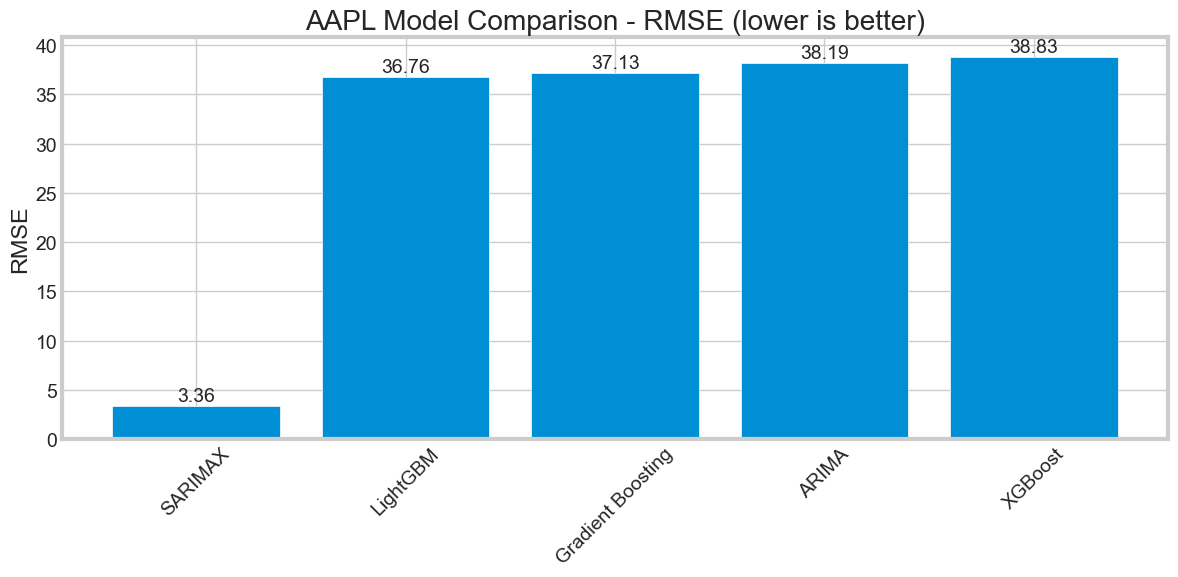

In [176]:
comparison_df = compare_all_models(
    ticker,
    arima_rmse=arima_rmse,
    sarimax_rmse=sarimax_rmse,
    gb_results=gb_results,
    xgb_results=xgb_results,
    lgb_results=lgb_results
)
results['comparison'] = comparison_df

In [179]:
# Generate future forecasts
forecast_results = forecast_future(ticker, results, days=30, artifacts_path=artifacts_path)
results['forecasts'] = forecast_results


--- Future Forecasting for AAPL ---
Best model based on RMSE: SARIMAX
Skipping ARIMA forecast (model not available)


Saved forecasts to E:/INVESTO-Stock-Predictor/artifacts\AAPL_future_forecasts.csv
Saved interactive plot to E:/INVESTO-Stock-Predictor/artifacts\AAPL_forecast_plot.html


In [180]:
print(results)

{'arima': {'metrics': {'Model': 'Mean Diff', 'RMSE': np.float64(38.185446317788454), 'MAE': 34.74762360626613, 'MAPE': np.float64(15.281901671393655), 'R2': -1.8455459261492675}, 'predictions': Date
2024-03-28    170.785005
2024-04-01    170.895907
2024-04-02    171.006809
2024-04-03    171.117711
2024-04-04    171.228613
                 ...    
2025-03-24    198.066903
2025-03-25    198.177805
2025-03-26    198.288707
2025-03-27    198.399609
2025-03-28    198.510511
Length: 251, dtype: float64, 'model_type': 'Mean Differencing'}, 'sarimax': {'metrics': {'Model': 'SARIMAX(0, 1, 2)x(0, 0, 1, 5)', 'RMSE': np.float64(3.361994084872535), 'MAE': 2.467117441555886, 'MAPE': np.float64(1.1337838186124671), 'R2': 0.9779421211430939}, 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x00000246A517E240>, 'predictions': Date
2024-03-28    170.594519
2024-04-01    169.247920
2024-04-02    168.059463
2024-04-03    168.984449
2024-04-04    167.960324
                 ...

In [ ]:
'''def run_all_models(ticker, artifacts_path='artifacts'):
    """Run all models, compare them, and save the results"""
    print(f"\nLoading data for {ticker}...")
    
    # Load data from artifacts directory
    try:
        data_dict = load_data(ticker)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None
    
    results = {}
    
    # Train ARIMA model
    print("\nTraining ARIMA model...")
    arima_results = train_arima_model(ticker, data_dict)
    if arima_results and 'metrics' in arima_results and 'RMSE' in arima_results['metrics']:
        arima_rmse = arima_results['metrics']['RMSE']
    else:
        arima_rmse = float('inf')
    results['arima'] = arima_results
    
    # Train SARIMAX model
    print("\nTraining SARIMAX model...")
    sarimax_results = train_sarimax_model(ticker, data_dict)
    if sarimax_results and 'metrics' in sarimax_results and 'RMSE' in sarimax_results['metrics']:
        sarimax_rmse = sarimax_results['metrics']['RMSE']
    else:
        sarimax_rmse = float('inf')
    results['sarimax'] = sarimax_results
    
    # Train Gradient Boosting
    print("\nTraining Gradient Boosting model...")
    gb_results = train_gradient_boosting(ticker, data_dict)
    results['gb'] = gb_results
    
    # Train XGBoost
    print("\nTraining XGBoost model...")
    xgb_results = train_xgboost_model(ticker, data_dict)
    results['xgb'] = xgb_results
    
    # Train LightGBM
    print("\nTraining LightGBM model...")
    lgb_results = train_lightgbm_model(ticker, data_dict)
    results['lgb'] = lgb_results
    
    # Save all trained models
    saved_paths = save_models(ticker, results, artifacts_path)
    results['saved_model_paths'] = saved_paths
    
    # Generate future forecasts
    forecast_results = forecast_future(ticker, results, days=30, artifacts_path=artifacts_path)
    results['forecasts'] = forecast_results
    
    return results

# Example usage - now much simpler:
ticker = "AAPL"
results = run_all_models(ticker, artifacts_path="artifacts")'''